## 0. Setup & instructions
- Put the Kaggle CSV `WA_Fn-UseC_-Telco-Customer-Churn.csv` (can be downloaded here: https://www.kaggle.com/datasets/blastchar/telco-customer-churn) in a `data/` folder.
- Run each cell in order in a Jupyter Notebook (or convert to .ipynb).

### 0.1 Installations

In [1]:
!pip install shap

### 0.2 Imports

In [87]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)
from scipy.stats import chi2_contingency
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import pearsonr
from scipy import stats
import xgboost as xgb
import shap
import scipy.stats as st
import numpy as np
import itertools
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

### 0.3 Utility functions and variables

In [3]:
NUMERICAL_FEATURES = ['tenure', 'MonthlyCharges', 'TotalCharges']

CATEGORICAL_FEATURES = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
]

BINARY_FEATURES = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Churn'
]

TARGET_FEATURE = 'Churn'


def plot_categorical_distribution(df, feature, top_n=None):
    """
    Plots distribution (counts & percentages) of a categorical feature.
    """
    plt.figure(figsize=(8,5))
    if top_n:
        top_values = df[feature].value_counts().index[:top_n]
        data = df[df[feature].isin(top_values)]
    else:
        data = df.copy()

    # Define order
    order = data[feature].value_counts().index

    ax = sns.countplot(x=feature, data=data, order=order)

    total = len(data)
    for p in ax.patches:
        count = int(p.get_height())
        percentage = 100 * count / total
        ax.annotate(f'{count}\n({percentage:.1f}%)',
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)

    plt.title(f'{feature} Distribution (Counts & Percentages)')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.show()


def plot_categorical_with_target(df, feature, target='Churn', top_n=None, colors=None):
    """
    Plots a categorical feature against a binary target as a stacked bar chart.
    Shows both counts and percentages of the target within each category.

    Parameters:
    - df: DataFrame
    - feature: str, categorical column
    - target: str, binary column
    - top_n: int, plot only top N categories by frequency
    - colors: list, colors for the bars [Non-Churn, Churn]
    """
    if colors is None:
        colors = ['#2ca02c', '#d62728']  # green = non-churn, red = churn

    # Filter top N categories if needed
    if top_n:
        top_values = df[feature].value_counts().index[:top_n]
        data = df[df[feature].isin(top_values)]
    else:
        data = df.copy()

    # Handle missing values
    data[feature] = data[feature].fillna('Missing')
    order = data[feature].value_counts().index

    # Crosstab counts and proportions
    counts = pd.crosstab(data[feature], data[target]).reindex(order).fillna(0)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100

    # Plot stacked bars
    ax = counts.plot(kind='bar', stacked=True, color=colors, alpha=0.8, figsize=(10,6))

    # Annotate bars with counts and percentages
    for i, cat in enumerate(counts.index):
        y_offset = 0
        for j, cls in enumerate(counts.columns):
            cnt = counts.loc[cat, cls]
            pct = percentages.loc[cat, cls].round(1)
            if cnt > 0:
                ax.text(i, y_offset + cnt/2, f'{cnt}\n({pct}%)',
                        ha='center', va='center', color='white', fontsize=9)
            y_offset += cnt

    plt.title(f'{feature} Distribution by {target}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title=target)
    plt.tight_layout()
    plt.show()
    return ax


def outlier_analysis_report(df, numerical_features=None, categorical_features=None, method='IQR'):
    """
    Generate a clean, unified outlier report for both numerical and categorical features.
    Returns a pandas DataFrame.
    """

    report_rows = []

    # Auto-detect features if not provided
    if numerical_features is None:
        numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    if categorical_features is None:
        categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Numerical features
    for col in numerical_features:
        data = df[col].dropna()
        if method == 'IQR':
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outliers = data[(data < lower) | (data > upper)]
        elif method == 'Z-score':
            mean = data.mean()
            std = data.std()
            z_scores = (data - mean) / std
            outliers = data[np.abs(z_scores) > 3]
        else:
            raise ValueError("method must be 'IQR' or 'Z-score'")

        report_rows.append({
            'Feature': col,
            'Type': 'Numerical',
            'Total Points': len(data),
            'Outlier Count': len(outliers),
            'Outlier %': round(len(outliers)/len(data)*100, 2)
        })

    # Categorical features
    for col in categorical_features:
        counts = df[col].value_counts()
        rare_threshold = 0.01  # <1% frequency
        rare_categories = counts[counts / len(df) < rare_threshold].index.tolist()

        report_rows.append({
            'Feature': col,
            'Type': 'Categorical',
            'Total Points': len(df),
            'Outlier Count': len(rare_categories),
            'Outlier %': round(len(rare_categories)/len(counts)*100, 2)
        })

    report_df = pd.DataFrame(report_rows)
    return report_df


def plot_numerical_binned_distribution(df, feature, bins=10):
    """
    Bins a numerical feature and plots distribution (counts & percentages) per bin.
    Shows bin edges as x-axis labels, preserving natural bin order.
    """
    plt.figure(figsize=(8,5))

    # Bin the numerical feature
    df['binned'] = pd.cut(df[feature], bins=bins)

    # Use the sorted categories order for the plot
    bin_categories = df['binned'].cat.categories

    ax = sns.countplot(x='binned', data=df, order=bin_categories)

    total = len(df)
    for p in ax.patches:
        count = int(p.get_height())
        percentage = 100 * count / total
        ax.annotate(f'{count}\n({percentage:.1f}%)',
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)

    plt.title(f'{feature} Distribution (Binned Counts & Percentages)')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # Clean up added column
    df.drop(columns=['binned'], inplace=True)


def plot_numerical_kde(df, feature):
    """
    Plots the KDE of a numerical feature.
    """
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df[feature], fill=True, color='blue', linewidth=2)
    plt.title(f'{feature} KDE')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()


def plot_numerical_binned_with_target(df, feature, target='Churn', bins=10):
    """
    Bins a numerical feature and plots churn distribution (%) per bin as stacked bars.
    Colors: red for 'Yes', green for 'No'.
    """
    plt.figure(figsize=(10,6))

    # Create bins (intervals)
    df['binned'] = pd.cut(df[feature], bins=bins)

    # Crosstab: for each bin, proportion of churn categories
    ct = pd.crosstab(df['binned'], df[target], normalize='index') * 100

    # Ensure correct color order based on column order in ct
    color_map = []
    for col in ct.columns:
        if str(col).strip().lower() == 'yes':
            color_map.append('red')
        else:
            color_map.append('green')

    # Plot stacked bar of churn % per bin
    ct.plot(kind='bar', stacked=True, color=color_map, alpha=0.8)

    plt.title(f'{feature} binned Distribution by {target} (%)')
    plt.xlabel(f'{feature} bins')
    plt.ylabel('Percentage within bin')
    plt.xticks(rotation=45)
    plt.legend(title=target)
    plt.tight_layout()
    plt.show()


def chi_test_and_visualize(df, col1, col2):
    """
    Performs a chi-squared test of independence between two categorical columns,
    and visualizes the results with a grouped bar chart and a standardized residuals heatmap.

    Parameters:
    - df: pandas DataFrame containing the data
    - col1: name of first categorical column (string)
    - col2: name of second categorical column (string)
    """
    # Create contingency table
    contingency = pd.crosstab(df[col1], df[col2])
    print(f"Contingency Table:\n{contingency}\n")

    # Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi-square statistic: {chi2:.3f}")
    print(f"Degrees of freedom: {dof}")
    print(f"P-value: {p:.5f}\n")

    # Grouped bar chart
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=col1, hue=col2, data=df)
    plt.title(f'Counts of {col1} grouped by {col2}')
    plt.xlabel(col1)
    plt.ylabel('Count')

    # Standardized residuals heatmap
    residuals = (contingency - expected) / np.sqrt(expected)
    plt.subplot(1, 2, 2)
    sns.heatmap(residuals, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Standardized Residual'})
    plt.title('Standardized Residuals Heatmap')
    plt.xlabel(col2)
    plt.ylabel(col1)

    plt.tight_layout()
    plt.show()


def categorical_feature_analysis(df, feature, target):
    """
    Performs Chi-square test of independence between a categorical feature
    and a binary target.

    Prints contingency table, chi-square statistic, p-value, degrees of freedom,
    and Cramér's V.

    Plots heatmaps of observed counts and standardized residuals side by side,
    both using a red-white-blue color palette.

    Also plots a simple horizontal bar showing the Cramér's V value.
    """

    # Create contingency table
    contingency_table = pd.crosstab(df[feature], df[target])

    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"P-value: {p:.5f}")

    # Calculate Cramér's V
    n = contingency_table.values.sum()
    min_dim = min(contingency_table.shape) - 1
    cramer_v = (chi2 / n / min_dim) ** 0.5
    print(f"Cramér's V: {cramer_v:.4f}")

    # Calculate standardized residuals
    observed = contingency_table.values
    std_residuals = (observed - expected) / (expected ** 0.5)
    residuals_df = pd.DataFrame(std_residuals, index=contingency_table.index, columns=contingency_table.columns)

    # Normalize observed counts around mean for red-white-blue palette
    mean_count = np.mean(observed)
    vmin_counts = observed.min()
    vmax_counts = observed.max()
    midpoint = mean_count

    # Create a diverging norm for counts centered at mean
    norm_counts = TwoSlopeNorm(vmin=vmin_counts, vcenter=midpoint, vmax=vmax_counts)

    # Create symmetric range for residuals centered at 0
    max_abs_resid = np.abs(std_residuals).max()
    norm_resid = TwoSlopeNorm(vmin=-max_abs_resid, vcenter=0, vmax=max_abs_resid)

    # Plot heatmaps and Cramér's V barplot
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Heatmap of observed counts
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap="seismic",
                norm=norm_counts, cbar=True, ax=axes[0])
    axes[0].set_title(f'Observed Counts: {feature} vs {target}')
    axes[0].set_ylabel(feature)
    axes[0].set_xlabel(target)

    # Heatmap of standardized residuals with 0 centered
    sns.heatmap(residuals_df, annot=True, cmap="seismic", norm=norm_resid, fmt='.2f',
                cbar_kws={'label': 'Standardized Residual'}, ax=axes[1])
    axes[1].set_title(f'Standardized Residuals: {feature} vs {target}')
    axes[1].set_ylabel(feature)
    axes[1].set_xlabel(target)

    # Barplot for Cramér's V
    axes[2].barh([0], [cramer_v], color='steelblue')
    axes[2].set_xlim(0, 1)
    axes[2].set_xlabel("Cramér's V")
    axes[2].set_yticks([])
    axes[2].set_title("Strength of Association")
    axes[2].text(cramer_v/2, 0, f"{cramer_v:.3f}", color='white', fontsize=14, ha='center', va='center')

    plt.tight_layout()
    plt.show()

def plot_numerical_distribution_by_target(df, feature, target='Churn'):
    """
    Visualize the distribution of a numerical feature split by Churn vs No Churn.
    """
    # Prepare data
    data = df[[feature, target]].dropna()

    # Map target to 0/1 if needed
    if set(data[target].unique()) == {'Yes', 'No'}:
        data[target] = data[target].map({'No': 0, 'Yes': 1})

    churn_0 = data[data[target] == 0][feature]
    churn_1 = data[data[target] == 1][feature]

    # KDE plots
    plt.figure(figsize=(8, 5))
    sns.kdeplot(churn_0, label='No Churn', fill=True, color='green')
    sns.kdeplot(churn_1, label='Churn', fill=True, color='red')
    plt.title(f"Distribution of {feature} by {target}")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


def numerical_feature_analysis(df, feature, target='Churn', best_fit=None):
    """
    Clean statistical analysis of a numerical feature with respect to a binary target.
    Computes descriptive statistics per target category, association tests, and MLE
    for the best-fitting distribution.

    Parameters:
    - df: pandas DataFrame
    - feature: str, numerical column name
    - target: str, binary column name (0/1 or Yes/No)
    - best_fit: str, name of best-fitting distribution ('normal', 'lognorm', 'gamma', etc.)
    """

    # Prepare data
    data = df[[feature, target]].copy()
    data[feature] = pd.to_numeric(data[feature], errors='coerce')
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    # Normalize labels to Yes/No for printing
    uniq = set(data[target].unique())
    if uniq == {0, 1}:
        data[target] = data[target].map({0: 'No', 1: 'Yes'})
    elif uniq == {'Yes', 'No'}:
        pass
    else:
        raise ValueError(f"Unexpected values in target column '{target}': {sorted(uniq)}")

    churn_no = data[data[target] == 'No'][feature]
    churn_yes = data[data[target] == 'Yes'][feature]

    # Descriptive statistics per category
    print(f"\n--- Descriptive statistics of '{feature}' by {target} ---")
    for label, group in [('No', churn_no), ('Yes', churn_yes)]:
        print(f"\n{target} = {label}:")
        if len(group) == 0:
            print("  (no data)")
            continue
        print(f"  Count: {len(group)}")
        print(f"  Mean: {group.mean():.3f}")
        print(f"  Std: {group.std():.3f}")
        print(f"  Min: {group.min():.3f}")
        print(f"  Max: {group.max():.3f}")

    # Association Tests
    print(f"\n--- Association Tests ---")
    try:
        if best_fit == 'normal':
            t_stat, t_p = stats.ttest_ind(churn_no, churn_yes, equal_var=False, nan_policy='omit')
            print(f"T-test (Welch): t={t_stat:.3f}, p={t_p:.4f}")
        else:
            u_stat, u_p = stats.mannwhitneyu(churn_no, churn_yes, alternative='two-sided')
            print(f"Mann–Whitney U: U={u_stat:.3f}, p={u_p:.4f}")
            r = u_stat / (len(churn_no) * len(churn_yes)) if (len(churn_no) and len(churn_yes)) else np.nan
            print(f"Effect size (r = U/(n1*n2)) = {r:.3f}")
    except Exception as e:
        print(f"(Association test skipped due to: {e})")

    # Robust variance test
    try:
        levene_p = stats.levene(churn_no, churn_yes, center='median')[1]
        print(f"Levene’s test p-value: {levene_p:.4f}")
    except Exception as e:
        print(f"(Levene’s test skipped due to: {e})")

    # KS test for full distribution
    try:
        ks_stat, ks_p = stats.ks_2samp(churn_no, churn_yes)
        print(f"KS test: statistic={ks_stat:.3f}, p={ks_p:.4f}")
    except Exception as e:
        print(f"(KS test skipped due to: {e})")

    # Point-biserial correlation (requires numeric target)
    try:
        num_target = data[target].map({'No': 0, 'Yes': 1})
        r_pb_res = stats.pointbiserialr(num_target, data[feature])
        # SciPy returns either a tuple or an object with .correlation
        r_pb = getattr(r_pb_res, 'correlation', r_pb_res[0] if isinstance(r_pb_res, tuple) else np.nan)
        print(f"Point-biserial correlation: r={r_pb:.3f}")
    except Exception as e:
        print(f"(Point-biserial correlation skipped due to: {e})")

    # MLE for best-fit distribution only
    if best_fit:
        print(f"\n--- MLE for best-fitting distribution ({best_fit}) ---")
        x = data[feature].to_numpy()

        if best_fit == 'normal':
            try:
                mu, sigma = stats.norm.fit(x)
                print(f"Mean: {mu:.3f}, Std: {sigma:.3f}")
            except Exception as e:
                print(f"(Normal MLE failed: {e})")

        elif best_fit == 'lognorm':
            # lognormal requires x > 0
            x_pos = x[np.isfinite(x) & (x > 0)]
            removed = np.sum(~np.isfinite(x)) + np.sum(x <= 0)
            if removed > 0:
                print(f"Note: removed {removed} non-positive/invalid values for lognormal fit.")
            if len(x_pos) == 0:
                print("Lognormal MLE skipped: no positive values available.")
            else:
                try:
                    shape, loc, scale = stats.lognorm.fit(x_pos, floc=0)  # standard parameterization
                    print(f"Shape: {shape:.6f}, Loc: {loc:.6f}, Scale: {scale:.6f}")
                except Exception as e:
                    print(f"(Lognormal MLE failed: {e})")

        elif best_fit == 'gamma':
            try:
                # Gamma can handle non-positives only via a fitted loc. Let loc be free.
                shape, loc, scale = stats.gamma.fit(x)  # do not fix loc
                print(f"Shape: {shape:.6f}, Loc: {loc:.6f}, Scale: {scale:.6f}")
            except Exception as e:
                print(f"(Gamma MLE failed: {e})")


def fit_distribution(df, feature, distributions=None):
    """
    Fits multiple distributions to a single numerical feature in a DataFrame,
    performs goodness-of-fit tests, and plots Q-Q plots.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data.
    feature : str
        Name of the numerical column to fit.
    distributions : list, optional
        List of scipy.stats distribution names to try.
        Defaults to ['norm', 'gamma', 'expon', 'lognorm'].
    """
    if distributions is None:
        distributions = ['norm', 'gamma', 'expon', 'lognorm']

    results = []

    data = df[feature].dropna()

    for dist_name in distributions:
        dist = getattr(st, dist_name)
        try:
            # Fit distribution
            params = dist.fit(data)

            # Kolmogorov–Smirnov test
            ks_stat, ks_p = st.kstest(data, dist_name, args=params)

            # Shapiro–Wilk for normality only
            shapiro_p = np.nan
            if dist_name == 'norm':
                shapiro_stat, shapiro_p = st.shapiro(data)

            # Store results
            results.append({
                'feature': feature,
                'distribution': dist_name,
                'params': params,
                'ks_stat': ks_stat,
                'ks_p': ks_p,
                'shapiro_p': shapiro_p
            })

            # Q–Q plot
            sm.qqplot(data, dist(*params), line='45')
            plt.title(f"Q-Q Plot: {feature} vs {dist_name}")
            plt.show()

        except Exception as e:
            print(f"Could not fit {dist_name} to {feature}: {e}")

    return pd.DataFrame(results)


def compute_vif(df, features):
    """
    Compute Variance Inflation Factor (VIF) for multicollinearity check.

    Parameters:
        df (pd.DataFrame): DataFrame containing the features
        features (list): List of numerical feature names

    Returns:
        pd.DataFrame: Features with their VIF scores
    """
    X = sm.add_constant(df[features])
    vif_data = pd.DataFrame({
        'Feature': X.columns,
        'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    return vif_data


def logistic_regression_mle(df, target, predictors):
    """
    Fit a logistic regression model (MLE) and return odds ratios.

    Parameters:
        df (pd.DataFrame): DataFrame with data
        target (str): Target column name (binary 0/1)
        predictors (list): List of predictor column names

    Returns:
        model: Fitted logistic regression model
        pd.DataFrame: Odds ratios with p-values
    """
    formula = f"{target} ~ {' + '.join(predictors)}"
    model = smf.logit(formula, data=df).fit(disp=False)
    odds_ratios = pd.DataFrame({
        'Feature': model.params.index,
        'Odds Ratio': np.exp(model.params),
        'p-value': model.pvalues
    })
    return model, odds_ratios


def wilson_ci_for_proportion_of_binary(successes, n, confidence=0.95):
    """
    Calculate Wilson score confidence interval for a proportion.

    Parameters:
    - successes: number of positive outcomes (e.g. churned customers)
    - n: total observations
    - confidence: confidence level (default 0.95)

    Returns:
    - (lower_bound, upper_bound)
    """
    if n == 0:
        return (0, 0)

    z = norm.ppf(1 - (1 - confidence) / 2)
    phat = successes / n
    denominator = 1 + z**2 / n
    center = (phat + z**2 / (2 * n)) / denominator
    margin = (z * np.sqrt((phat * (1 - phat) + z**2 / (4 * n)) / n)) / denominator

    lower_bound = center - margin
    upper_bound = center + margin

    return lower_bound, upper_bound


def ci_for_mean_of_numeric(df, column, ci=0.95, plot=True):
    """
    Performs univariate analysis on a numeric column:
    - Computes mean and confidence interval
    - Fits an exponential distribution using method of moments / MLE
    - Optionally plots histogram with exponential fit

    Parameters:
        df (pd.DataFrame): DataFrame containing the column
        column (str): Name of numeric column to analyze
        ci (float): Confidence level for the mean (default 0.95)
        plot (bool): Whether to plot histogram with exponential fit (default True)

    Returns:
        dict: containing mean, confidence interval, and lambda for exponential fit
    """
    # Drop missing values
    data = df[column].dropna()

    # Mean and confidence interval
    mean_val = data.mean()
    se = stats.sem(data)
    conf_int = stats.t.interval(ci, len(data)-1, loc=mean_val, scale=se)

    # Exponential fit (MOM & MLE)
    lambda_exp = 1 / mean_val

    # Print results
    print(f"Mean {column}: {mean_val:.3f}  {int(ci*100)}% CI: ({conf_int[0]:.3f}, {conf_int[1]:.3f})")
    print(f"Exponential λ (MOM & MLE for Exp): {lambda_exp:.5f}")

    # Optional histogram with exponential fit
    if plot:
        x = np.linspace(0, data.max(), 100)
        pdf = lambda_exp * np.exp(-lambda_exp * x)

        plt.figure(figsize=(8,5))
        plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
        plt.plot(x, pdf, 'r-', lw=2, label=f'Exp Fit λ={lambda_exp:.3f}')
        plt.title(f'Histogram and Exponential Fit for {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    # Return results
    return {
        'mean': mean_val,
        'ci': conf_int,
        'lambda_exp': lambda_exp
    }


import plotly.express as px


def numerical_to_target_plot_violin(df, numeric_var, target_var='Churn'):
    """
    Creates a violin plot for a numeric variable against a target variable.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data
    numeric_var (str): Column name of the numeric variable
    target_var (str): Column name of the target variable (categorical/binary)
    """
    fig = px.violin(
        df,
        x=target_var,
        y=numeric_var,
        box=True,  # shows embedded boxplot inside the violin
        points=False,
        color=target_var,
        color_discrete_map={
            'Yes': 'red',
            'No': 'green'
        }
    )

    # Update y-axis properties
    fig.update_yaxes(title_text=numeric_var, row=1, col=1)
    # Update x-axis properties
    fig.update_xaxes(title_text=target_var, row=1, col=1)

    # Update size and title
    fig.update_layout(
        autosize=True,
        width=750,
        height=600,
        title_font=dict(size=25, family='Courier'),
        title=f'<b>{numeric_var} vs {target_var}</b>',
    )

    fig.show()


def encode_telco_dataset(df, binary_features, numerical_features, categorical_features):
    df = df.copy()

    # Binary features: Map Yes/No to 1/0
    for col in binary_features:
        df[col] = df[col].replace({'Yes': 1, 'No': 0,
                                   'Male': 1,
                                   'Female': 0})

    # Numerical features: Ensure numeric & handle missing
    for col in numerical_features:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col].fillna(df[col].median(), inplace=True)

    # Categorical features: One-hot encoding
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    return df


def train_and_optimize(X_train, y_train, X_eval, y_eval, n_iter=30):
    # Parameter search space
    param_grid = {
        'n_estimators': [200, 400, 600, 800, 1000],
        'max_depth': [3, 4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.85, 1.0],
        'colsample_bytree': [0.7, 0.85, 1.0],
        'reg_lambda': [0.1, 1, 10],
        'reg_alpha': [0, 0.1, 1],
        'min_child_weight': [1, 3, 5]
    }

    base_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',  # faster
        random_state=42,
        use_label_encoder=False
    )

    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='roc_auc',
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    print(f"Best params: {search.best_params_}")

    # Evaluate
    preds_eval = best_model.predict_proba(X_eval)[:, 1]
    auc_eval = roc_auc_score(y_eval, preds_eval)
    print(f"Validation ROC-AUC: {auc_eval:.4f}")

    return best_model, auc_eval


def evaluate_model(name, model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

    print(f" Model Evaluation: {name}\n")

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}\n")

    # Classification report
    print(" Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel("Prediction")
    plt.ylabel("Real Value")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f' ROC curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(5, 4))
    plt.plot(recall, precision, color='green')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve - {name}')
    plt.grid()
    plt.show


def explain_xgboost_with_shap(model, X, sample_index=None, show_summary=True, show_waterfall=True):
    """
    Generates SHAP explanations for a fitted XGBoost model.

    Parameters:
        model : XGBoost model (XGBClassifier or XGBRegressor)
        X : pd.DataFrame
            The input features used for training or evaluation.
        sample_index : int or None
            Index of the sample to explain individually (for waterfall plot).
        show_summary : bool
            Whether to show the global summary plot.
        show_waterfall : bool
            Whether to show an individual waterfall plot.
    """
    print("Calculating SHAP values...")
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    if show_summary:
        print("Generating summary plot...")
        shap.summary_plot(shap_values, X)

    if show_waterfall and sample_index is not None:
        print(f"Generating waterfall plot for sample index: {sample_index}")
        shap.plots.waterfall(shap_values[sample_index])

## 1. Load data

In [4]:
PATH = 'data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
try:
    df = pd.read_csv(PATH)
except FileNotFoundError:
    raise FileNotFoundError(f"CSV not found at {PATH}. Download the dataset from Kaggle and place it there.")

print('rows, cols:', df.shape)
df.head()

rows, cols: (7043, 21)


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

## 2. Exploratory Data Analysis (EDA)

### 2.0 General characteristics

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


We can see the 11 values are missing for TotalCharges, we'll drop them.

In [6]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Let's see how many unique values we have for each feature

In [7]:
for col in df.columns:
    print(f"Column: {col}")
    print(f"Number of unique values: {df[col].nunique()}")
    print("Unique values:", df[col].unique())
    print("-" * 40)

Column: customerID
Number of unique values: 7043
Unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
----------------------------------------
Column: gender
Number of unique values: 2
Unique values: ['Female' 'Male']
----------------------------------------
Column: SeniorCitizen
Number of unique values: 2
Unique values: [0 1]
----------------------------------------
Column: Partner
Number of unique values: 2
Unique values: ['Yes' 'No']
----------------------------------------
Column: Dependents
Number of unique values: 2
Unique values: ['No' 'Yes']
----------------------------------------
Column: tenure
Number of unique values: 73
Unique values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
----------------------------------------
Column: PhoneService
Number of un

Initial data insights:
1. The dataset has 21 features and 7043 (7032 after we removed missing values) samples.
2. The TotalCharges feature needs casting from object to float.
3. The data seems to have no other missing values, nor duplicate values.

Let's convert TotalCharges to numeric

In [8]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Check:

In [9]:
df['TotalCharges'].dtype

dtype('float64')

#### 2.0.1 Outlier detection

In [10]:
outlier_analysis_report(df=df, numerical_features=NUMERICAL_FEATURES, categorical_features=list(set(CATEGORICAL_FEATURES + BINARY_FEATURES)))

Feature         Type  Total Points  Outlier Count  Outlier %
0             tenure    Numerical          7043              0        0.0
1     MonthlyCharges    Numerical          7043              0        0.0
2       TotalCharges    Numerical          7032              0        0.0
3    InternetService  Categorical          7043              0        0.0
4        StreamingTV  Categorical          7043              0        0.0
5    StreamingMovies  Categorical          7043              0        0.0
6           Contract  Categorical          7043              0        0.0
7   PaperlessBilling  Categorical          7043              0        0.0
8     OnlineSecurity  Categorical          7043              0        0.0
9              Churn  Categorical          7043              0        0.0
10            gender  Categorical          7043              0        0.0
11      PhoneService  Categorical          7043              0        0.0
12  DeviceProtection  Categorical          7043              0        0.0
13      OnlineBackup  Categorical          7043              0        0.0
14     PaymentMethod  Categorical          7043              0        0.0
15       TechSupport  Categorical          7043              0        0.0
16     SeniorCitizen  Categorical          7043              0        0.0
17     MultipleLines  Categorical          7043              0        0.0
18           Partner  Categorical          7043              0        0.0
19        Dependents  Categorical          7043              0        0.0

As we can see, we have no outliers and our dataset is pretty clean.

#### 2.0.2 Numerical features summary

In [11]:
df.describe().T

count         mean          std    min     25%       50%  \
SeniorCitizen   7043.0     0.162147     0.368612   0.00    0.00     0.000   
tenure          7043.0    32.371149    24.559481   0.00    9.00    29.000   
MonthlyCharges  7043.0    64.761692    30.090047  18.25   35.50    70.350   
TotalCharges    7032.0  2283.300441  2266.771362  18.80  401.45  1397.475   

                      75%      max  
SeniorCitizen      0.0000     1.00  
tenure            55.0000    72.00  
MonthlyCharges    89.8500   118.75  
TotalCharges    3794.7375  8684.80

### 2.1 Univariate and bivariate (with the target feature - churn) analyses

#### 2.1.1 Categorical features

##### 2.1.1.1 Churn

Whether the customer churned or not at the end of the month (Yes or No)

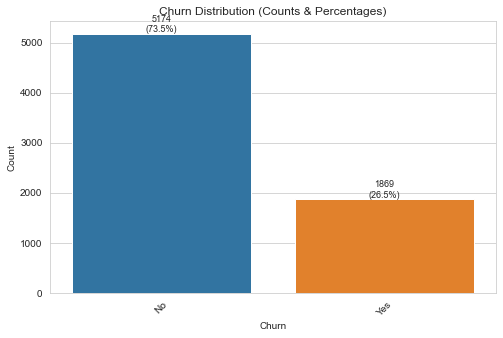

In [12]:
plot_categorical_distribution(df, 'Churn')

In [13]:
wilson_ci_for_proportion_of_binary((df['Churn'] == 'Yes').sum(), len(df))

(0.25518811288450727, 0.2758074374889079)

We can say with 95% confidence level that the true churn rate for that group in the population is between approximately 25.5% and 27.6%.

##### 2.1.1.2 Gender

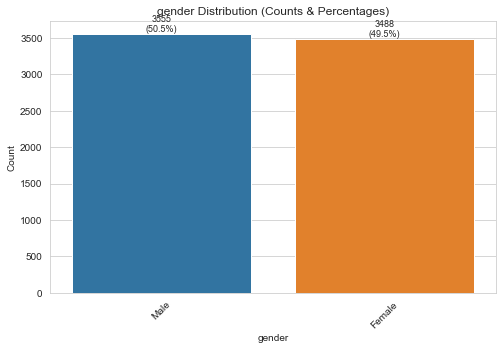

In [14]:
plot_categorical_distribution(df, 'gender')

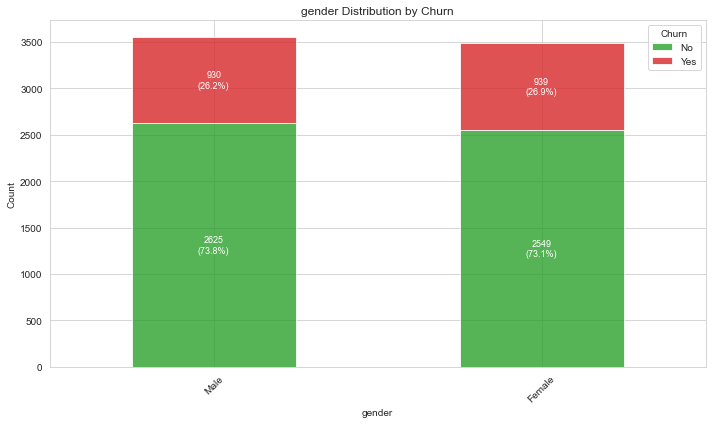

<AxesSubplot:title={'center':'gender Distribution by Churn'}, xlabel='gender', ylabel='Count'>

In [15]:
plot_categorical_with_target(df, 'gender')

Chi-square statistic: 0.4841
Degrees of freedom: 1
P-value: 0.48658
Cramér's V: 0.0083


posx and posy should be finite values


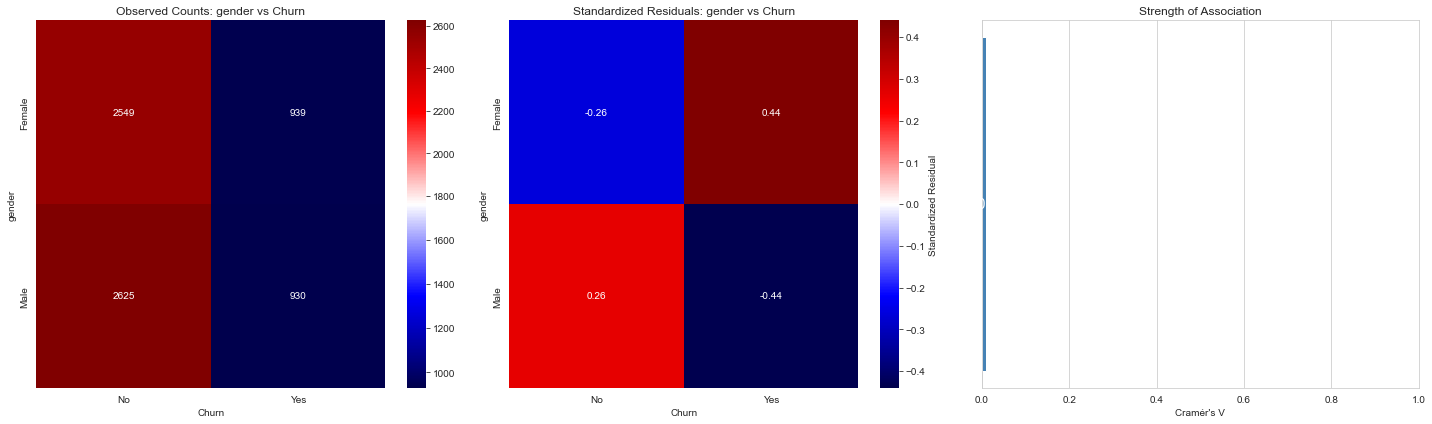

In [16]:
categorical_feature_analysis(df, 'gender', 'Churn')

##### 2.1.1.3 Senior citizen

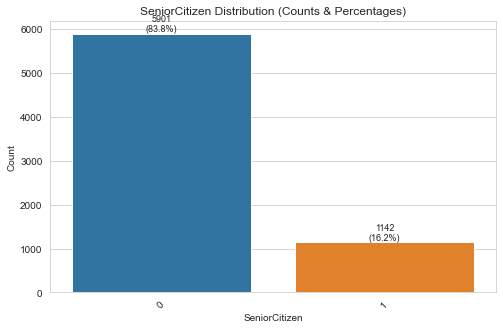

In [17]:
plot_categorical_distribution(df, 'SeniorCitizen')

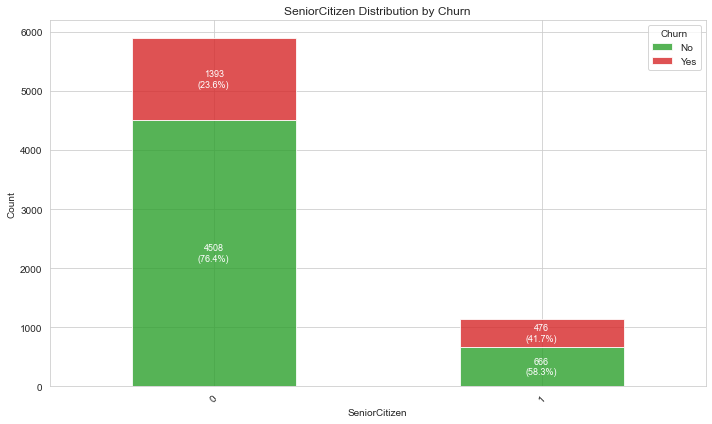

<AxesSubplot:title={'center':'SeniorCitizen Distribution by Churn'}, xlabel='SeniorCitizen', ylabel='Count'>

In [18]:
plot_categorical_with_target(df, 'SeniorCitizen')

Chi-square statistic: 159.4263
Degrees of freedom: 1
P-value: 0.00000
Cramér's V: 0.1505


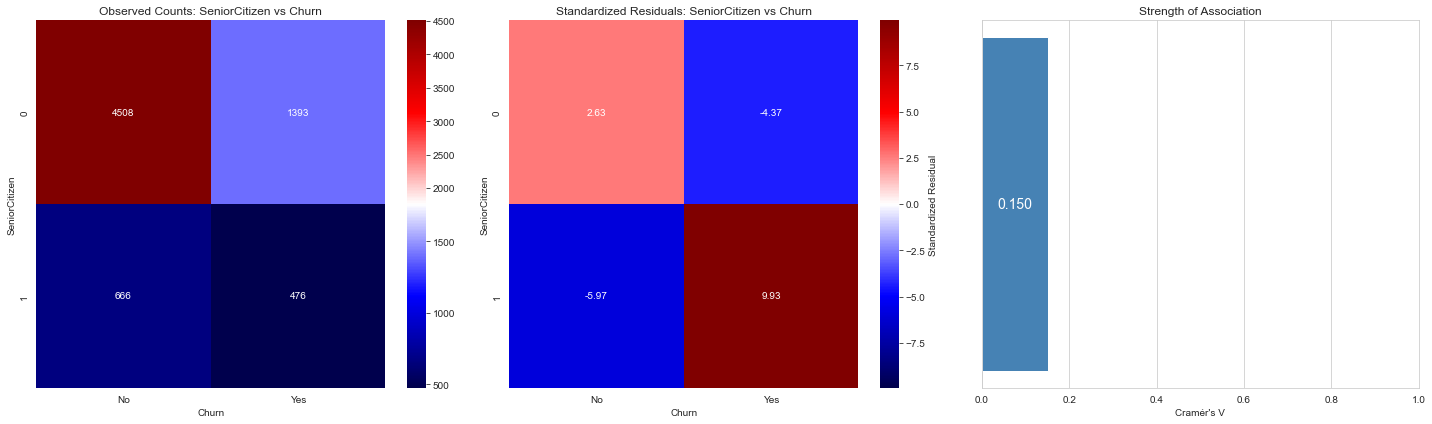

In [19]:
categorical_feature_analysis(df, 'SeniorCitizen', 'Churn')

##### 2.1.1.4 Partner

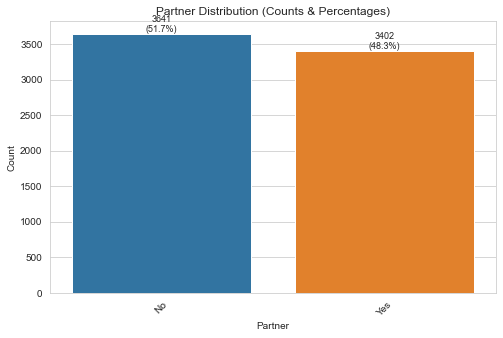

In [20]:
plot_categorical_distribution(df, 'Partner')

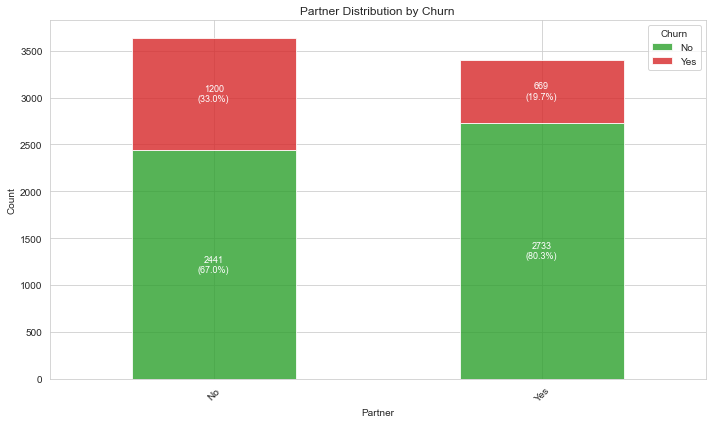

<AxesSubplot:title={'center':'Partner Distribution by Churn'}, xlabel='Partner', ylabel='Count'>

In [21]:
plot_categorical_with_target(df, 'Partner')

Chi-square statistic: 158.7334
Degrees of freedom: 1
P-value: 0.00000
Cramér's V: 0.1501


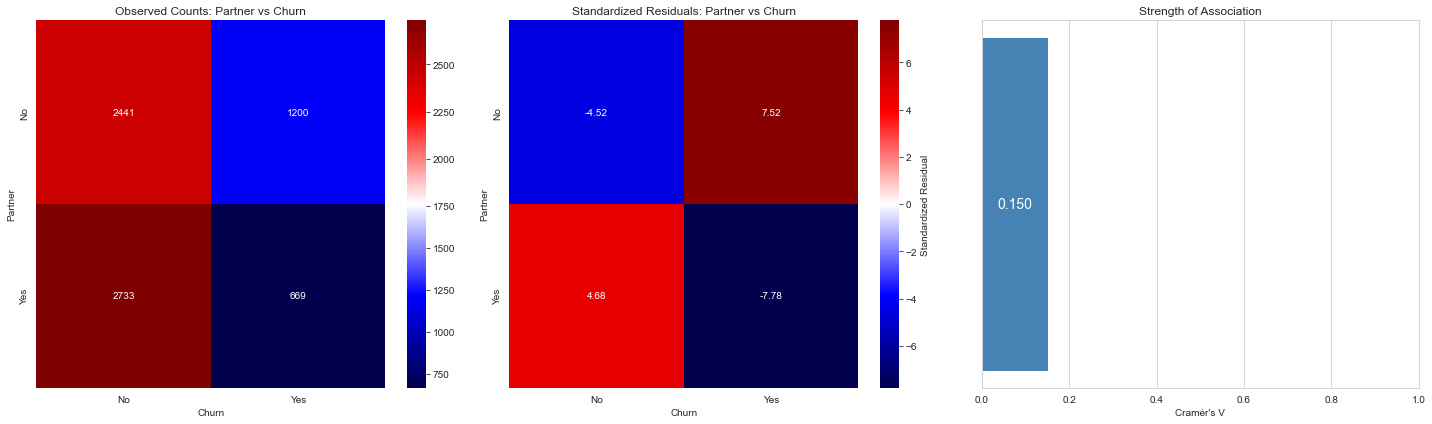

In [22]:
categorical_feature_analysis(df, 'Partner', 'Churn')

##### 2.1.1.5 Dependents

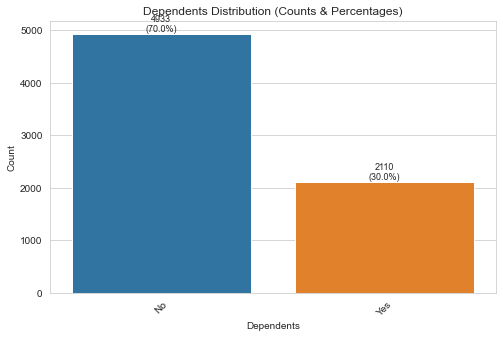

In [23]:
plot_categorical_distribution(df, 'Dependents')

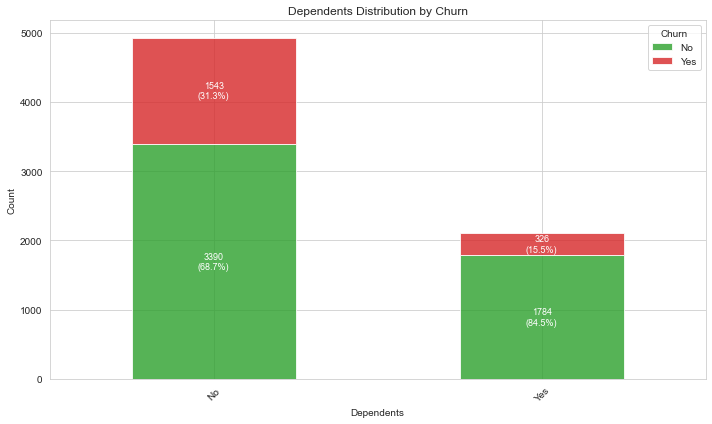

<AxesSubplot:title={'center':'Dependents Distribution by Churn'}, xlabel='Dependents', ylabel='Count'>

In [24]:
plot_categorical_with_target(df, 'Dependents')

Chi-square statistic: 189.1292
Degrees of freedom: 1
P-value: 0.00000
Cramér's V: 0.1639


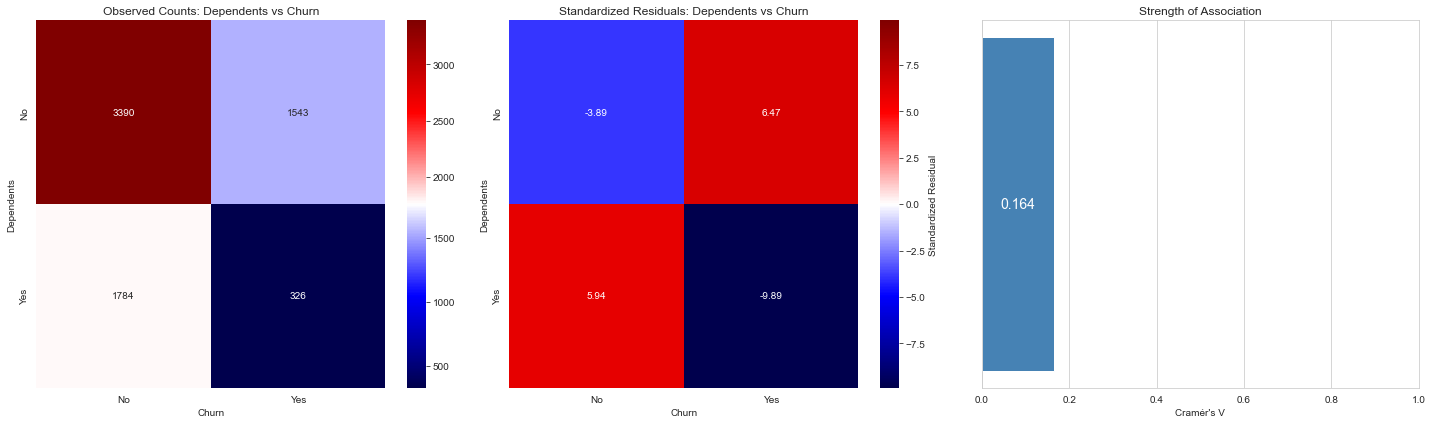

In [25]:
categorical_feature_analysis(df, 'Dependents', 'Churn')

##### 2.1.1.6 Phone service

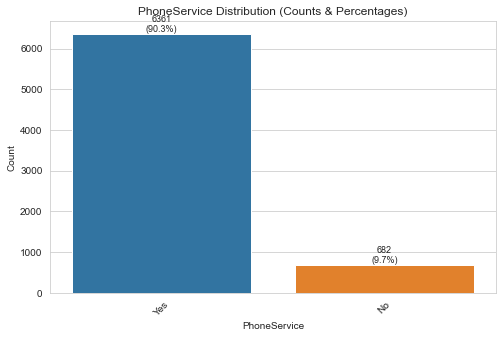

In [26]:
plot_categorical_distribution(df, 'PhoneService')

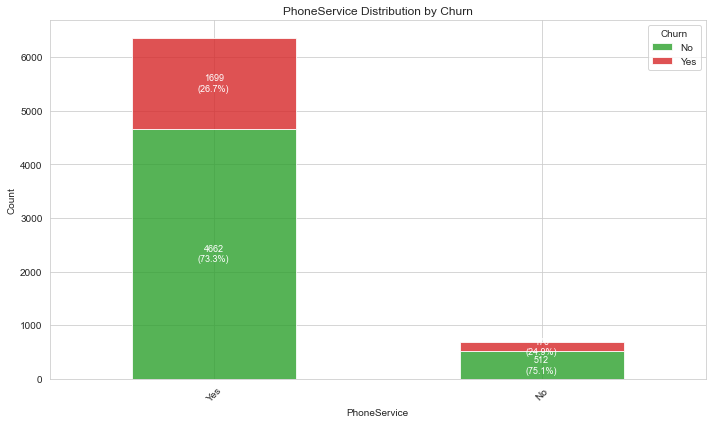

<AxesSubplot:title={'center':'PhoneService Distribution by Churn'}, xlabel='PhoneService', ylabel='Count'>

In [27]:
plot_categorical_with_target(df, 'PhoneService')

Chi-square statistic: 0.9150
Degrees of freedom: 1
P-value: 0.33878
Cramér's V: 0.0114


posx and posy should be finite values


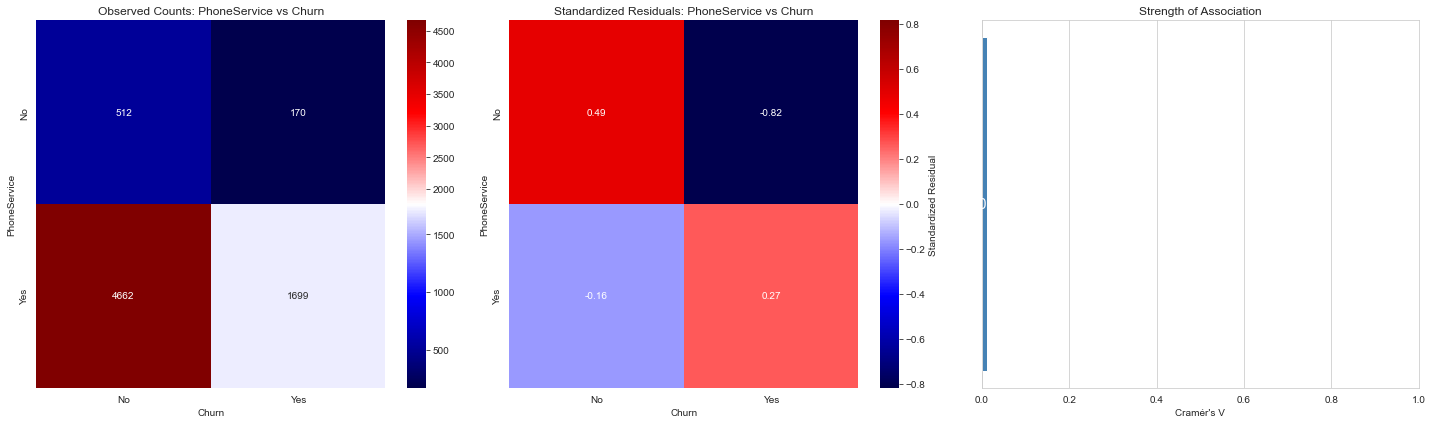

In [28]:
categorical_feature_analysis(df, 'PhoneService', 'Churn')

##### 2.1.1.7 Multiple lines

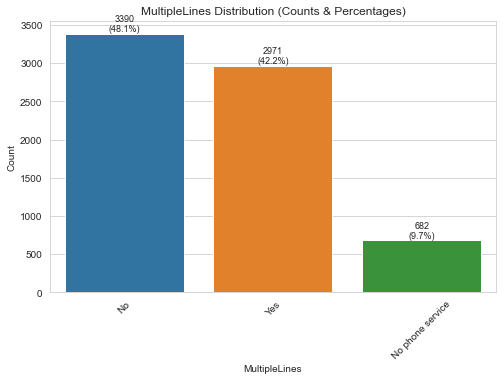

In [29]:
plot_categorical_distribution(df, 'MultipleLines')

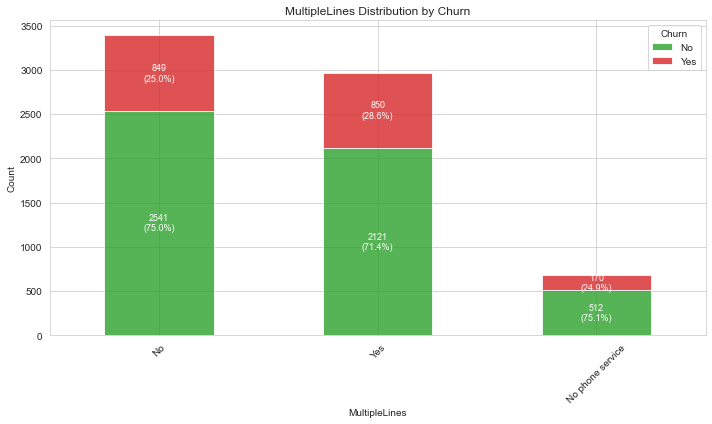

<AxesSubplot:title={'center':'MultipleLines Distribution by Churn'}, xlabel='MultipleLines', ylabel='Count'>

In [30]:
plot_categorical_with_target(df, 'MultipleLines')

Chi-square statistic: 11.3304
Degrees of freedom: 2
P-value: 0.00346
Cramér's V: 0.0401


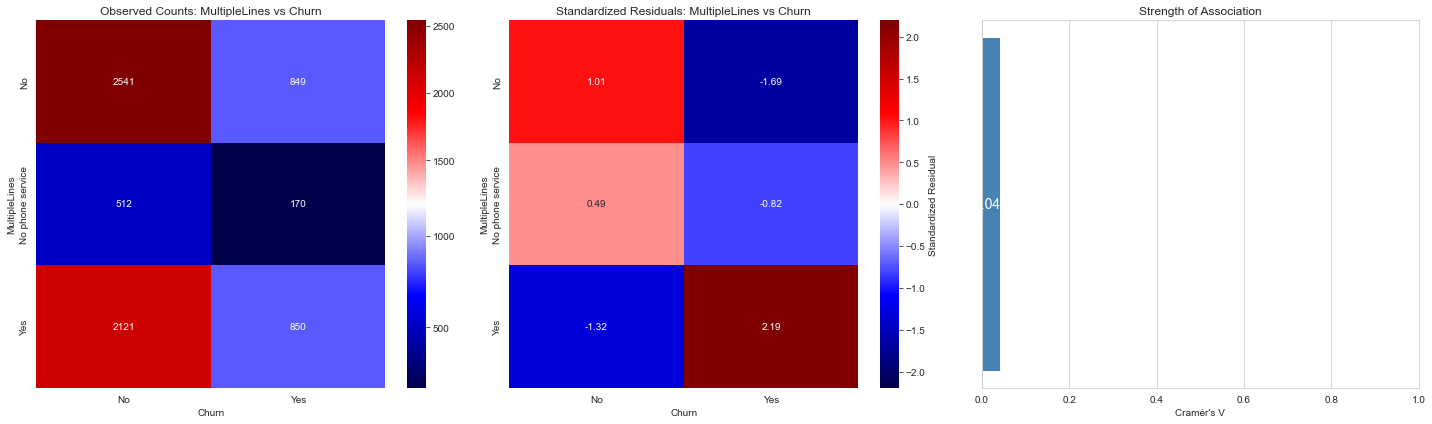

In [31]:
categorical_feature_analysis(df, 'MultipleLines', 'Churn')

##### 2.1.1.8 Internet service

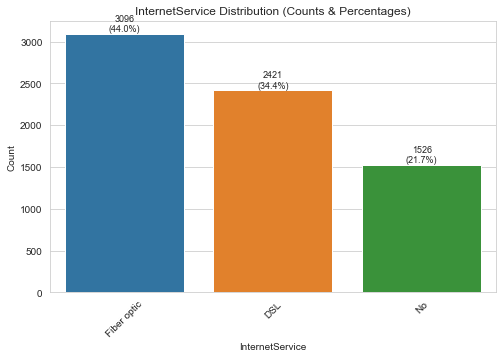

In [32]:
plot_categorical_distribution(df, 'InternetService')

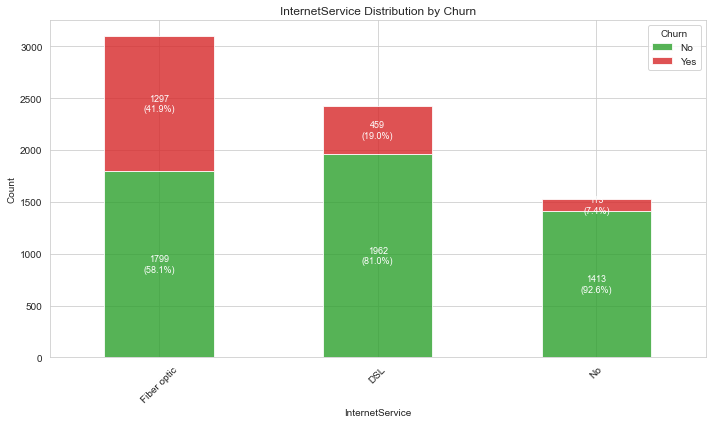

<AxesSubplot:title={'center':'InternetService Distribution by Churn'}, xlabel='InternetService', ylabel='Count'>

In [33]:
plot_categorical_with_target(df, 'InternetService')

Chi-square statistic: 732.3096
Degrees of freedom: 2
P-value: 0.00000
Cramér's V: 0.3225


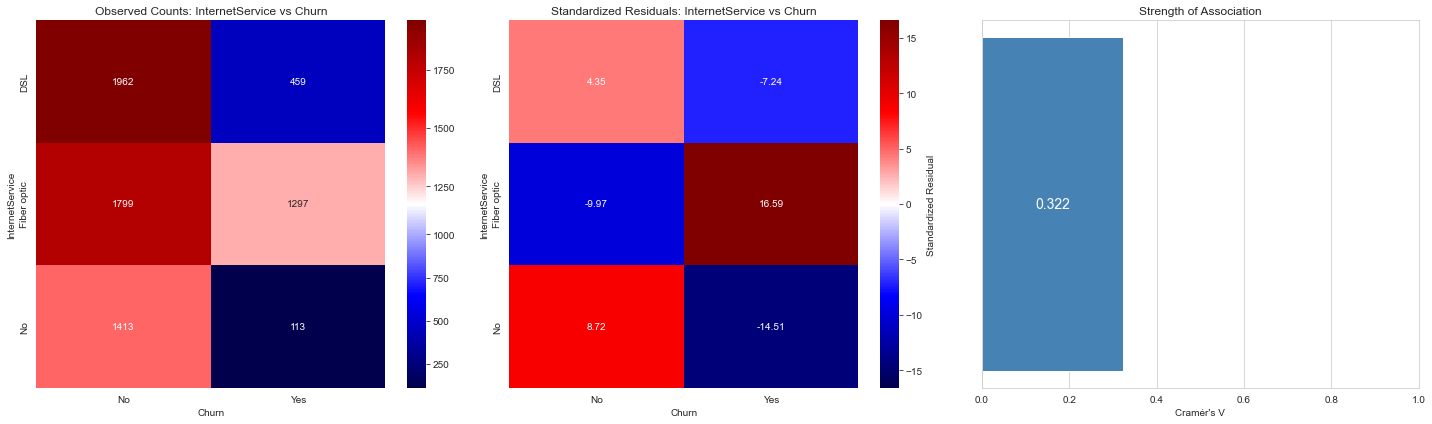

In [34]:
categorical_feature_analysis(df, 'InternetService', 'Churn')

##### 2.1.1.9 Online security

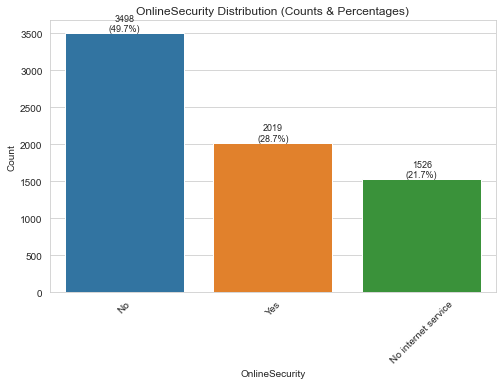

In [35]:
plot_categorical_distribution(df, 'OnlineSecurity')

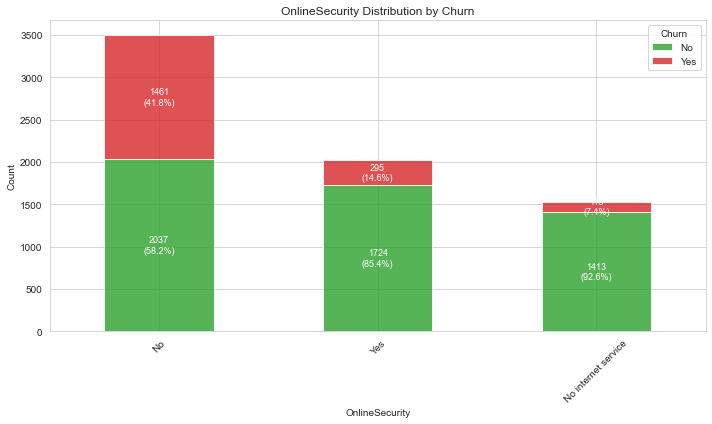

<AxesSubplot:title={'center':'OnlineSecurity Distribution by Churn'}, xlabel='OnlineSecurity', ylabel='Count'>

In [36]:
plot_categorical_with_target(df, 'OnlineSecurity')

Chi-square statistic: 849.9990
Degrees of freedom: 2
P-value: 0.00000
Cramér's V: 0.3474


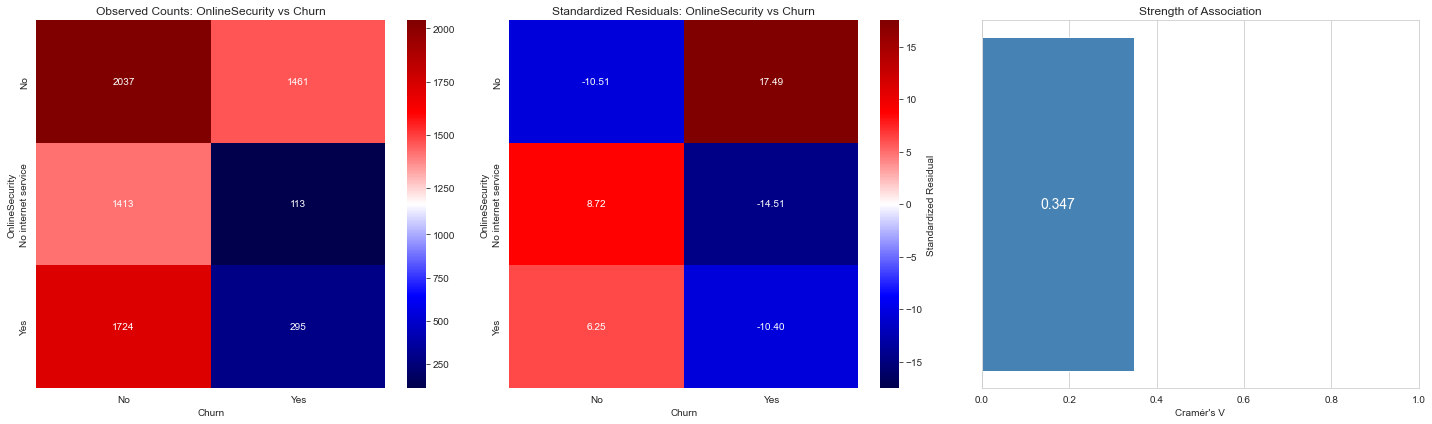

In [37]:
categorical_feature_analysis(df, 'OnlineSecurity', 'Churn')

##### 2.1.1.10 Online backup

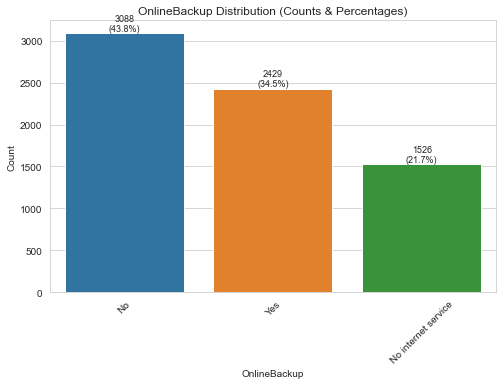

In [38]:
plot_categorical_distribution(df, 'OnlineBackup')

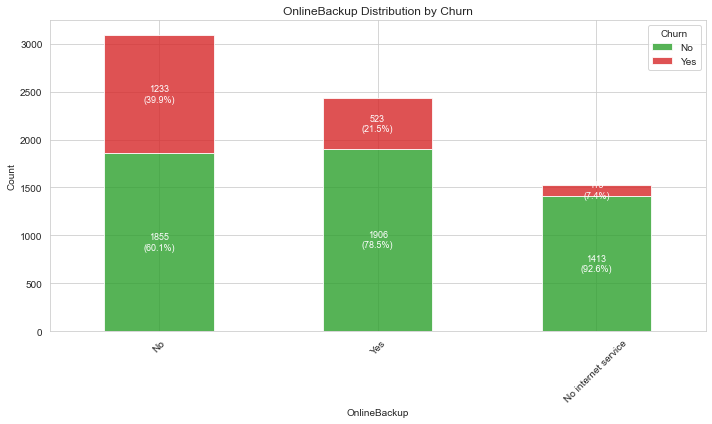

<AxesSubplot:title={'center':'OnlineBackup Distribution by Churn'}, xlabel='OnlineBackup', ylabel='Count'>

In [39]:
plot_categorical_with_target(df, 'OnlineBackup')

Chi-square statistic: 601.8128
Degrees of freedom: 2
P-value: 0.00000
Cramér's V: 0.2923


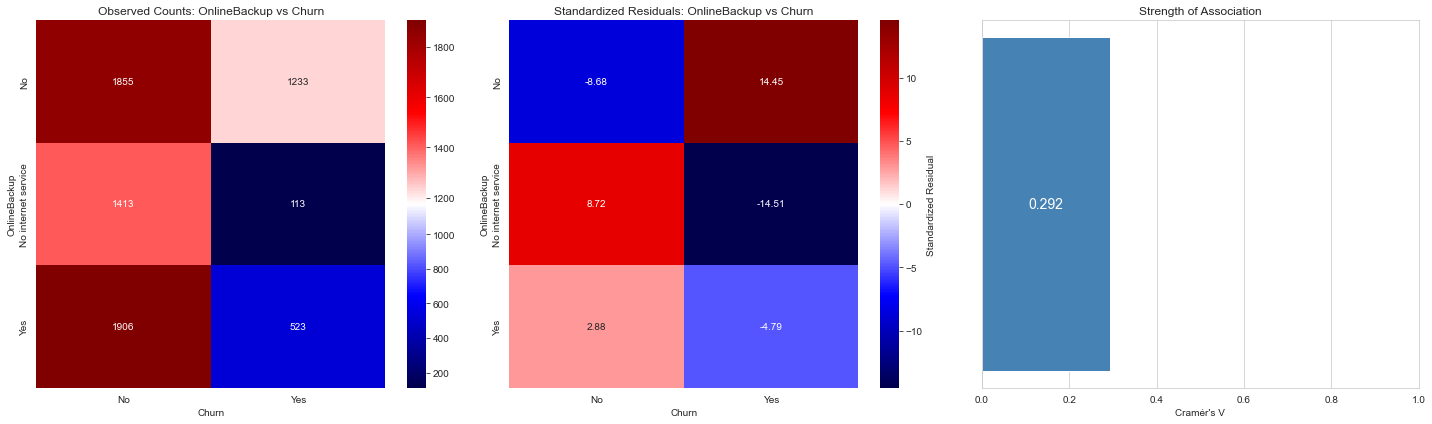

In [40]:
categorical_feature_analysis(df, 'OnlineBackup', 'Churn')

##### 2.1.1.11 Device protection

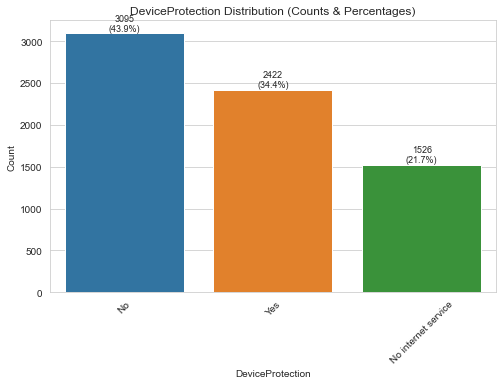

In [41]:
plot_categorical_distribution(df, 'DeviceProtection')

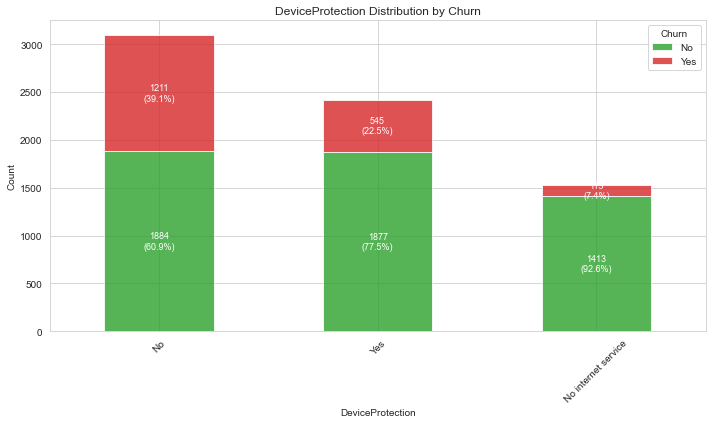

<AxesSubplot:title={'center':'DeviceProtection Distribution by Churn'}, xlabel='DeviceProtection', ylabel='Count'>

In [42]:
plot_categorical_with_target(df, 'DeviceProtection')

Chi-square statistic: 558.4194
Degrees of freedom: 2
P-value: 0.00000
Cramér's V: 0.2816


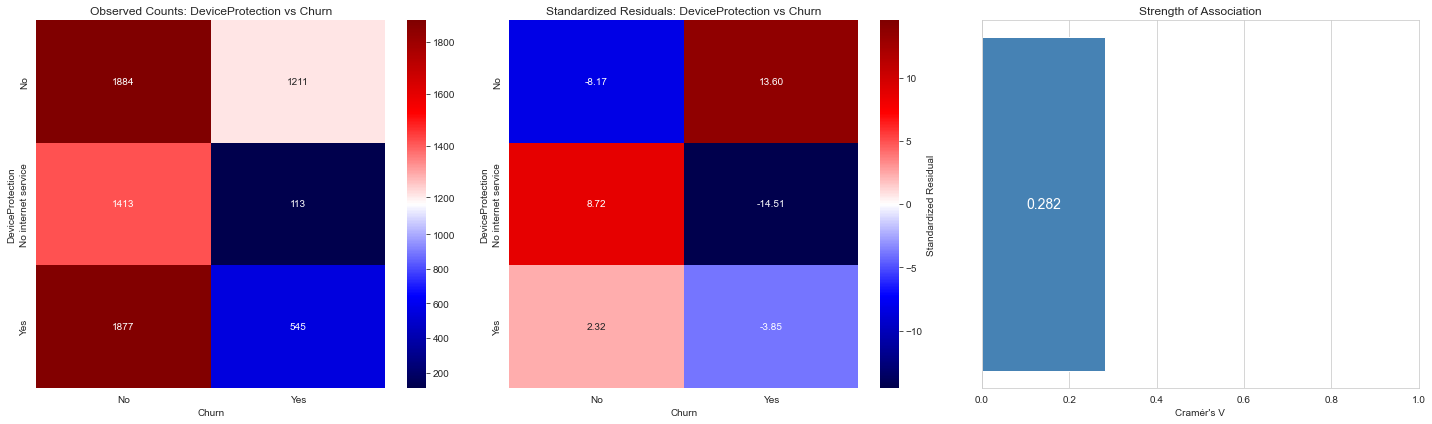

In [43]:
categorical_feature_analysis(df, 'DeviceProtection', 'Churn')

##### 2.1.1.12 Tech support

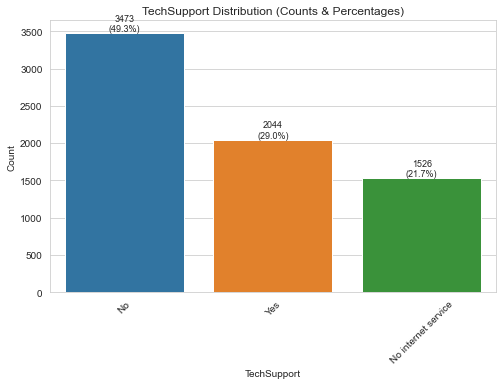

In [44]:
plot_categorical_distribution(df, 'TechSupport')

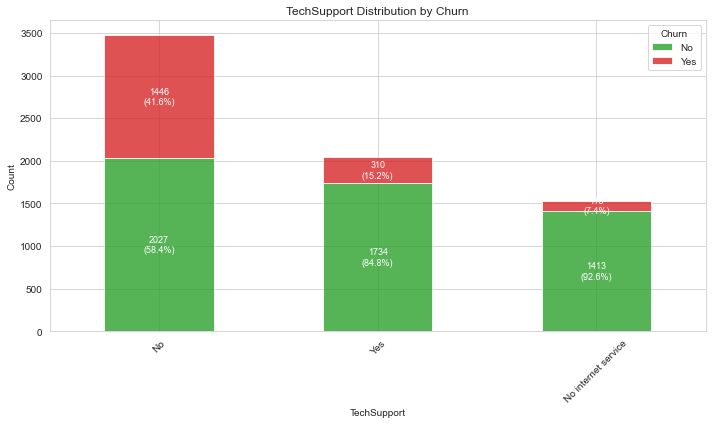

<AxesSubplot:title={'center':'TechSupport Distribution by Churn'}, xlabel='TechSupport', ylabel='Count'>

In [45]:
plot_categorical_with_target(df, 'TechSupport')

Chi-square statistic: 828.1971
Degrees of freedom: 2
P-value: 0.00000
Cramér's V: 0.3429


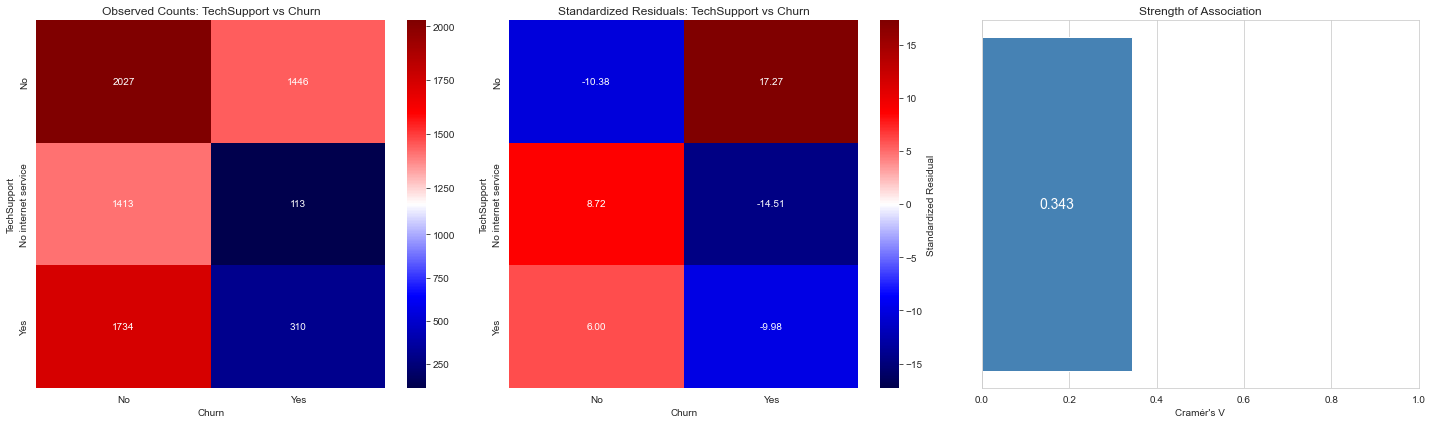

In [46]:
categorical_feature_analysis(df, 'TechSupport', 'Churn')

##### 2.1.1.13 Streaming TV

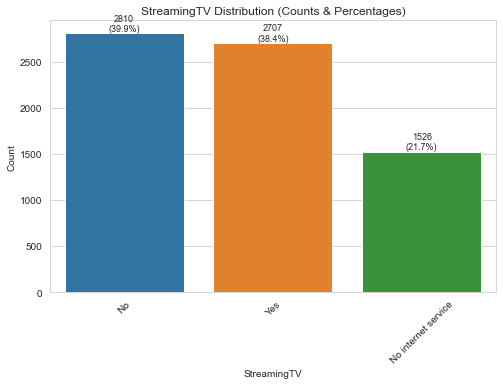

In [47]:
plot_categorical_distribution(df, 'StreamingTV')

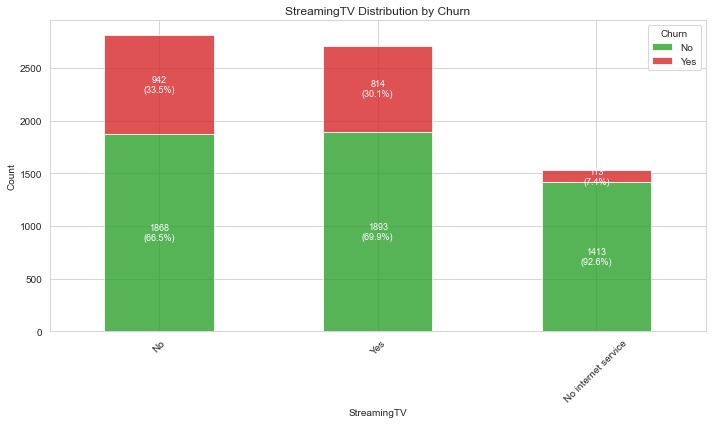

<AxesSubplot:title={'center':'StreamingTV Distribution by Churn'}, xlabel='StreamingTV', ylabel='Count'>

In [48]:
plot_categorical_with_target(df, 'StreamingTV')

Chi-square statistic: 374.2039
Degrees of freedom: 2
P-value: 0.00000
Cramér's V: 0.2305


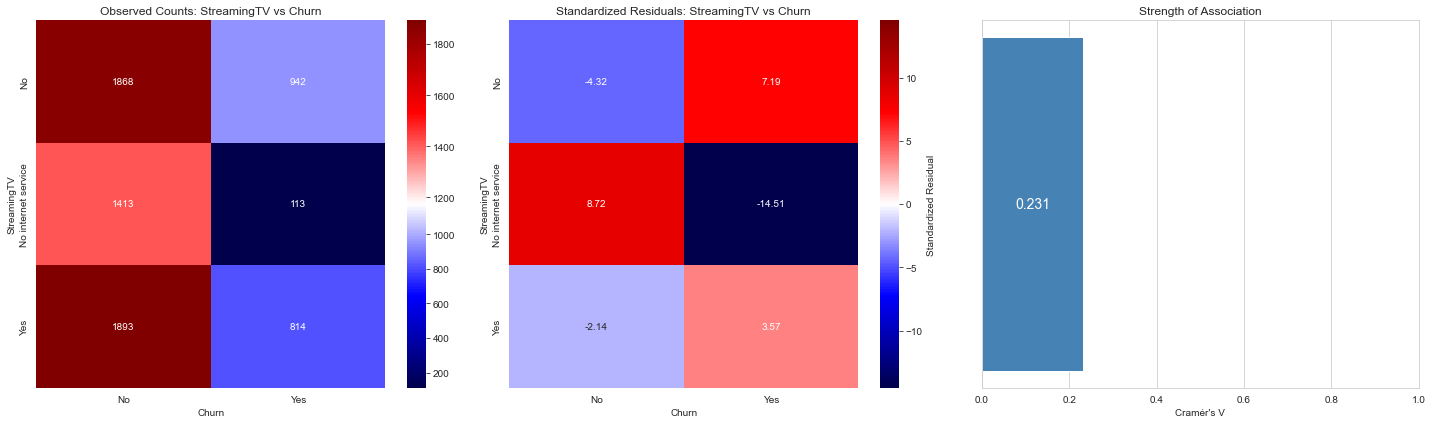

In [49]:
categorical_feature_analysis(df, 'StreamingTV', 'Churn')

##### 2.1.1.14 Streaming movies

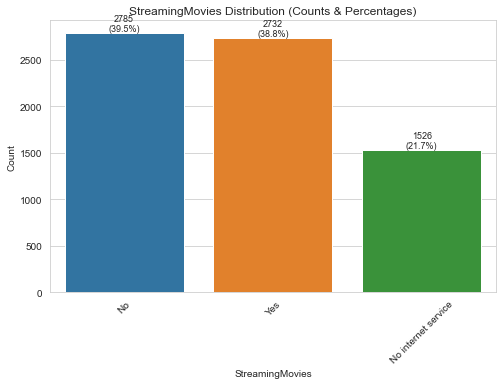

In [50]:
plot_categorical_distribution(df, 'StreamingMovies')

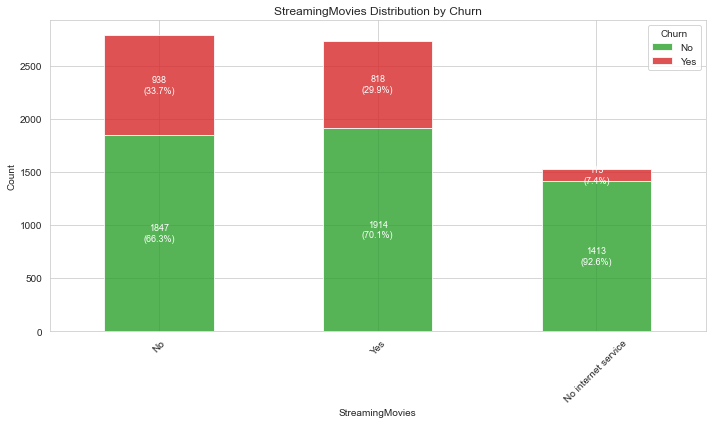

<AxesSubplot:title={'center':'StreamingMovies Distribution by Churn'}, xlabel='StreamingMovies', ylabel='Count'>

In [51]:
plot_categorical_with_target(df, 'StreamingMovies')

Chi-square statistic: 375.6615
Degrees of freedom: 2
P-value: 0.00000
Cramér's V: 0.2310


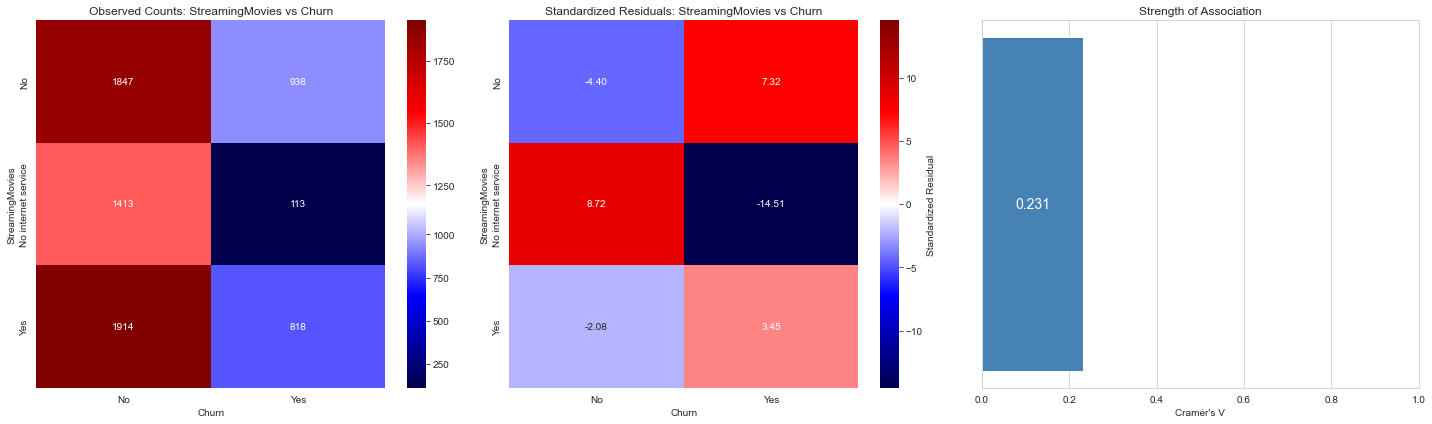

In [52]:
categorical_feature_analysis(df, 'StreamingMovies', 'Churn')

##### 2.1.1.15 Contract

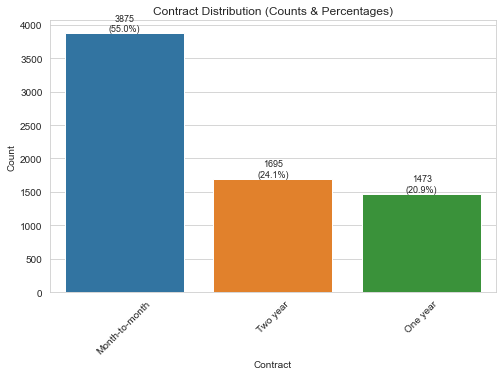

In [53]:
plot_categorical_distribution(df, 'Contract')

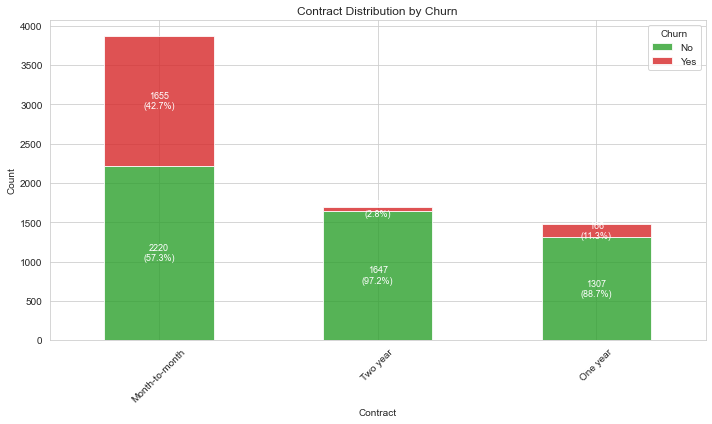

<AxesSubplot:title={'center':'Contract Distribution by Churn'}, xlabel='Contract', ylabel='Count'>

In [54]:
plot_categorical_with_target(df, 'Contract')

Chi-square statistic: 1184.5966
Degrees of freedom: 2
P-value: 0.00000
Cramér's V: 0.4101


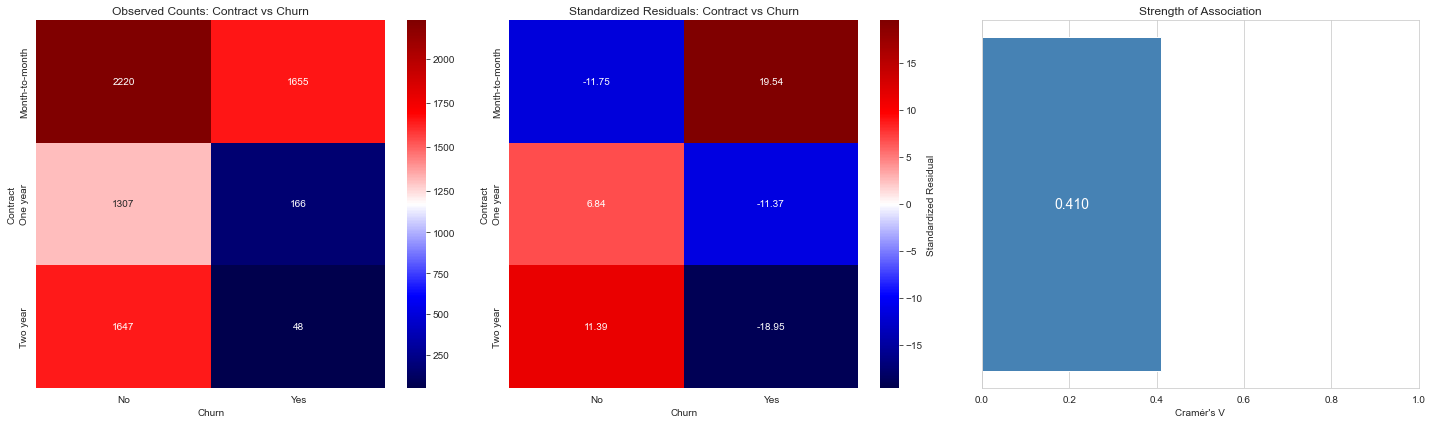

In [55]:
categorical_feature_analysis(df, 'Contract', 'Churn')

##### 2.1.1.16 Paperless billing

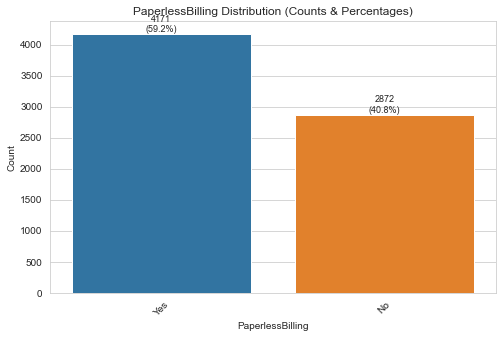

In [56]:
plot_categorical_distribution(df, 'PaperlessBilling')

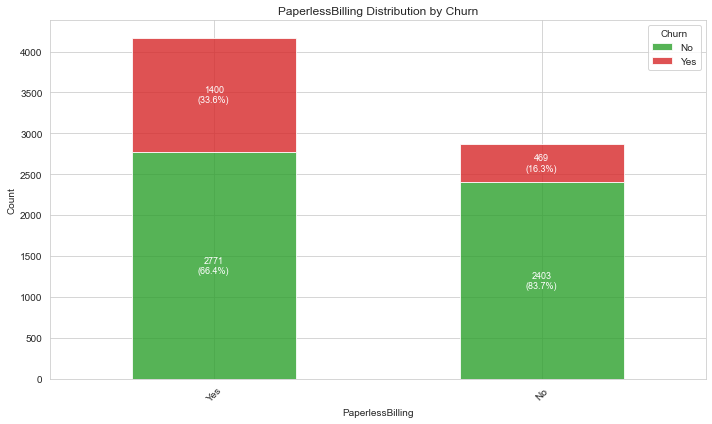

<AxesSubplot:title={'center':'PaperlessBilling Distribution by Churn'}, xlabel='PaperlessBilling', ylabel='Count'>

In [57]:
plot_categorical_with_target(df, 'PaperlessBilling')

Chi-square statistic: 258.2776
Degrees of freedom: 1
P-value: 0.00000
Cramér's V: 0.1915


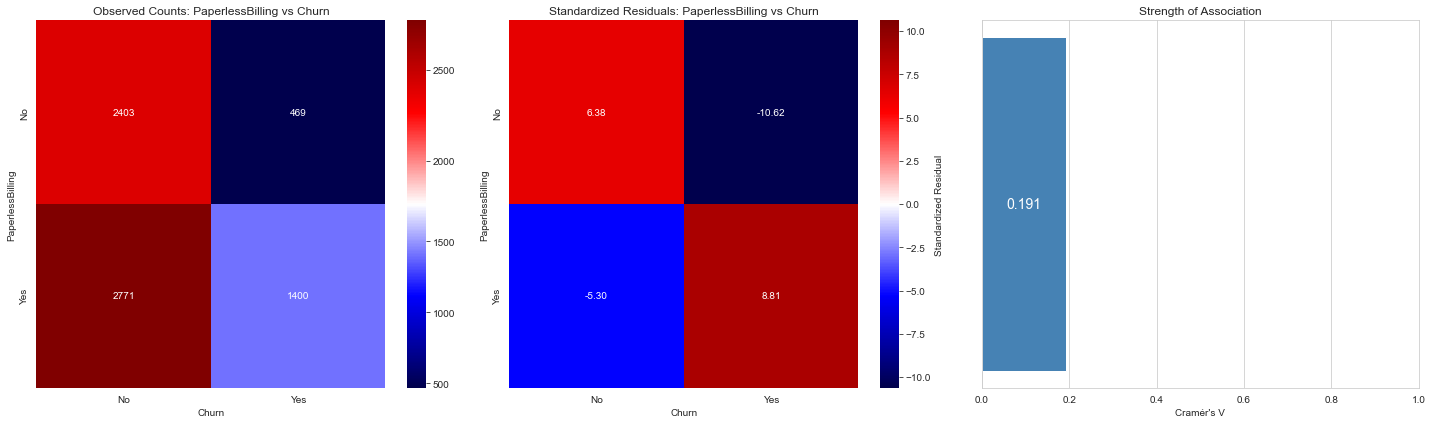

In [58]:
categorical_feature_analysis(df, 'PaperlessBilling', 'Churn')

##### 2.1.1.17 Payment method

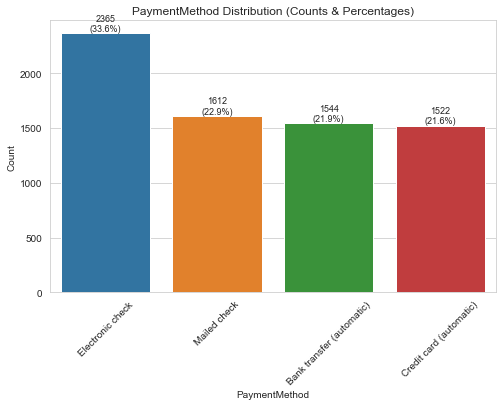

In [59]:
plot_categorical_distribution(df, 'PaymentMethod')

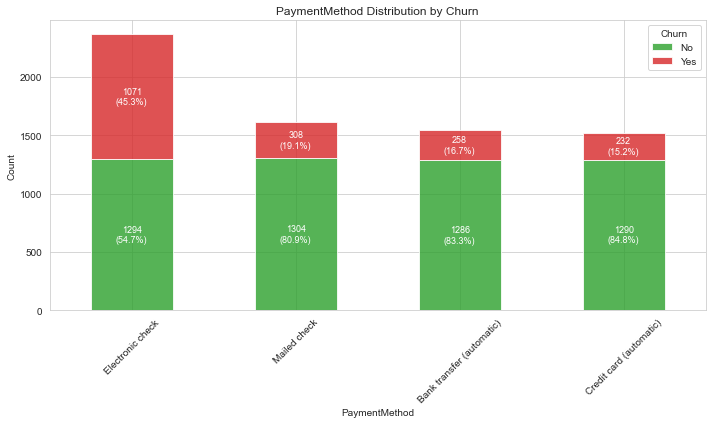

<AxesSubplot:title={'center':'PaymentMethod Distribution by Churn'}, xlabel='PaymentMethod', ylabel='Count'>

In [60]:
plot_categorical_with_target(df, 'PaymentMethod')

Chi-square statistic: 648.1423
Degrees of freedom: 3
P-value: 0.00000
Cramér's V: 0.3034


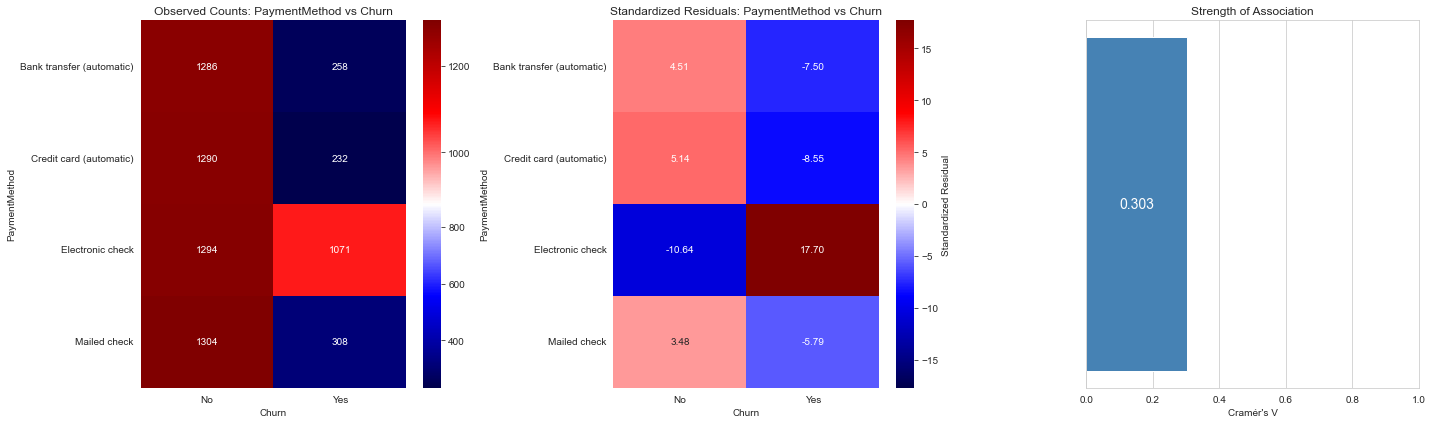

In [61]:
categorical_feature_analysis(df, 'PaymentMethod', 'Churn')

#### 2.1.2 Numerical features

##### 2.1.2.1 Tenure

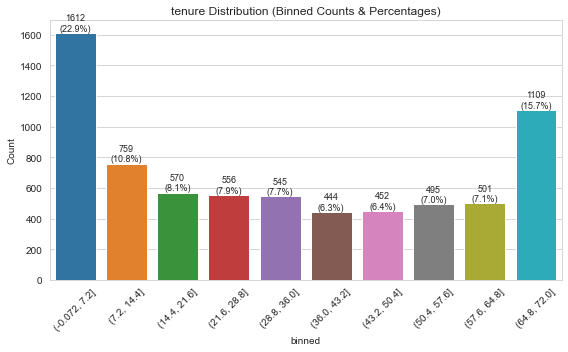

In [62]:
plot_numerical_binned_distribution(df, 'tenure')

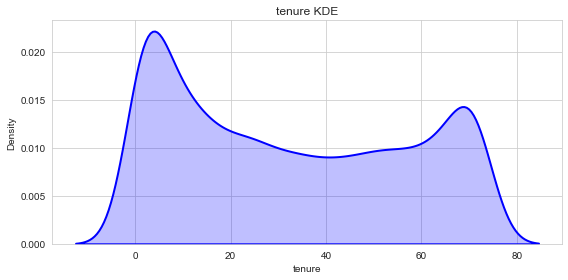

In [63]:
plot_numerical_kde(df, 'tenure')

<Figure size 720x432 with 0 Axes>

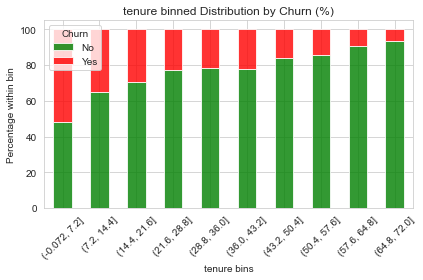

In [64]:
plot_numerical_binned_with_target(df, 'tenure')

In [65]:
numerical_to_target_plot_violin(df, 'tenure')

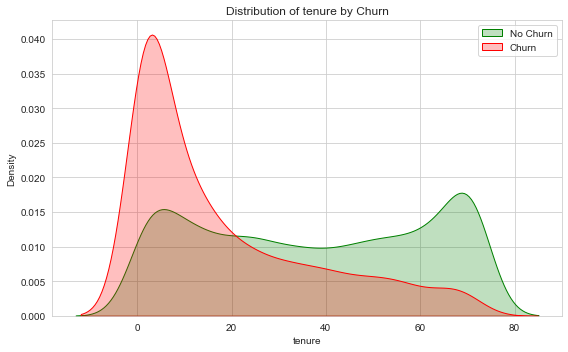

In [66]:
plot_numerical_distribution_by_target(df, 'tenure')

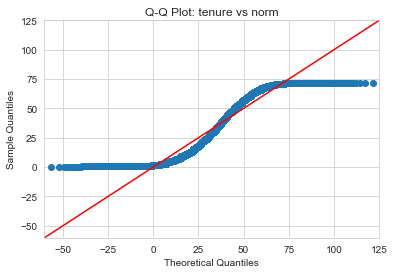

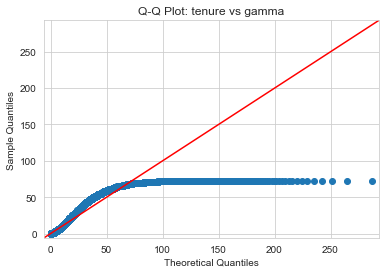

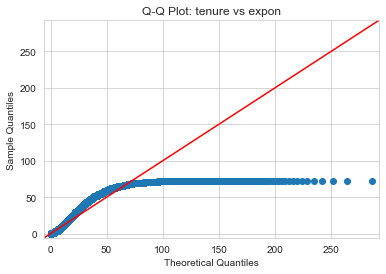

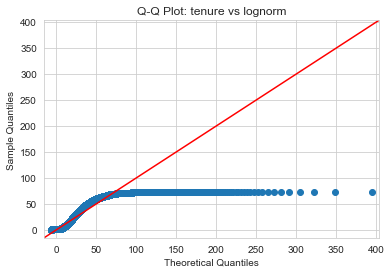

feature distribution                                             params  \
0  tenure         norm             (32.37114865824223, 24.55773742286344)   
1  tenure        gamma  (0.9938711133953264, -1.9667132627218019e-07, ...   
2  tenure        expon                           (0.0, 32.37114865824223)   
3  tenure      lognorm  (0.6760834906560531, -10.359922011346825, 34.8...   

    ks_stat          ks_p  shapiro_p  
0  0.111031  4.439432e-76        0.0  
1  0.110867  7.430329e-76        NaN  
2  0.109899  1.535385e-74        NaN  
3  0.108816  4.399719e-73        NaN

In [67]:
fit_distribution(df, 'tenure')

In [68]:
numerical_feature_analysis(df, 'tenure', best_fit='lognorm')


--- Descriptive statistics of 'tenure' by Churn ---

Churn = No:
  Count: 5174
  Mean: 37.570
  Std: 24.114
  Min: 0.000
  Max: 72.000

Churn = Yes:
  Count: 1869
  Mean: 17.979
  Std: 19.531
  Min: 1.000
  Max: 72.000

--- Association Tests ---
Mann–Whitney U: U=7154668.000, p=0.0000
Effect size (r = U/(n1*n2)) = 0.740
Levene’s test p-value: 0.0000
KS test: statistic=0.357, p=0.0000
Point-biserial correlation: r=-0.352

--- MLE for best-fitting distribution (lognorm) ---
Note: removed 11 non-positive/invalid values for lognormal fit.
Shape: 1.324859, Loc: 0.000000, Scale: 18.501842


##### 2.1.2.2 Monthly charges

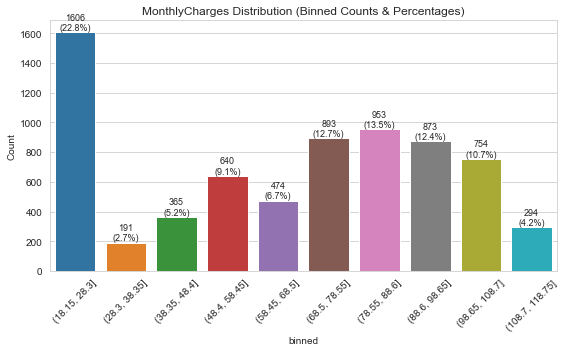

In [69]:
plot_numerical_binned_distribution(df, 'MonthlyCharges')

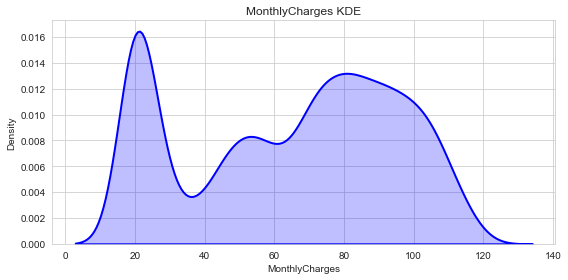

In [70]:
plot_numerical_kde(df, 'MonthlyCharges')

<Figure size 720x432 with 0 Axes>

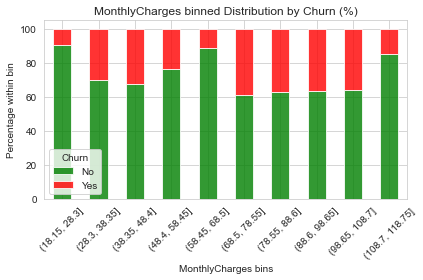

In [71]:
plot_numerical_binned_with_target(df, 'MonthlyCharges')

In [72]:
numerical_to_target_plot_violin(df, 'MonthlyCharges')

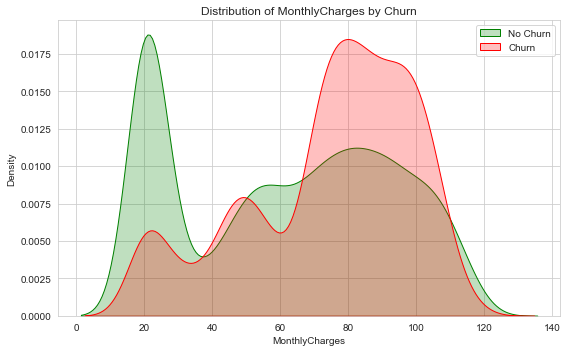

In [73]:
plot_numerical_distribution_by_target(df, 'MonthlyCharges')

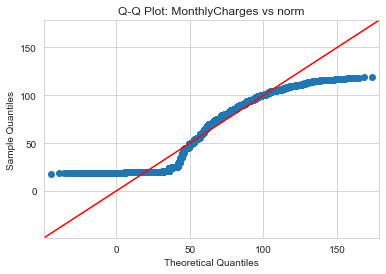

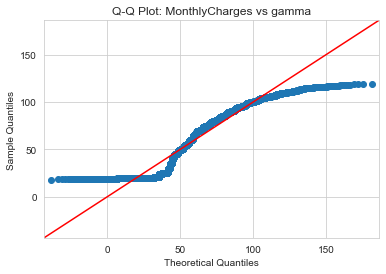

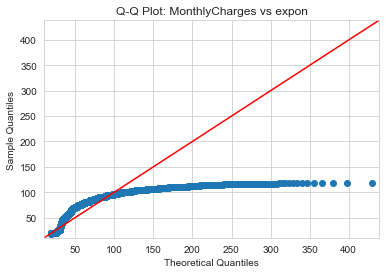

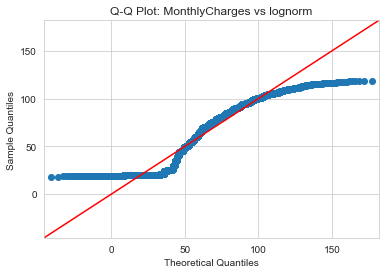

feature distribution  \
0  MonthlyCharges         norm   
1  MonthlyCharges        gamma   
2  MonthlyCharges        expon   
3  MonthlyCharges      lognorm   

                                              params   ks_stat           ks_p  \
0            (64.76169246059918, 30.087910854936975)  0.126211   2.976198e-98   
1  (320.5369517006978, -478.5210144036946, 1.6945...  0.125827   1.174392e-97   
2                         (18.25, 46.51169246059918)  0.196101  8.838582e-238   
3  (0.018555285726237214, -1560.270341475275, 162...  0.126379   1.628939e-98   

   shapiro_p  
0        0.0  
1        NaN  
2        NaN  
3        NaN

In [74]:
fit_distribution(df, 'MonthlyCharges')

In [75]:
numerical_feature_analysis(df, 'MonthlyCharges', best_fit='gamma')


--- Descriptive statistics of 'MonthlyCharges' by Churn ---

Churn = No:
  Count: 5174
  Mean: 61.265
  Std: 31.093
  Min: 18.250
  Max: 118.750

Churn = Yes:
  Count: 1869
  Mean: 74.441
  Std: 24.666
  Min: 18.850
  Max: 118.350

--- Association Tests ---
Mann–Whitney U: U=3667080.500, p=0.0000
Effect size (r = U/(n1*n2)) = 0.379
Levene’s test p-value: 0.0000
KS test: statistic=0.249, p=0.0000
Point-biserial correlation: r=0.193

--- MLE for best-fitting distribution (gamma) ---
Shape: 320.536952, Loc: -478.521014, Scale: 1.694515


##### 2.1.2.3 Total charges

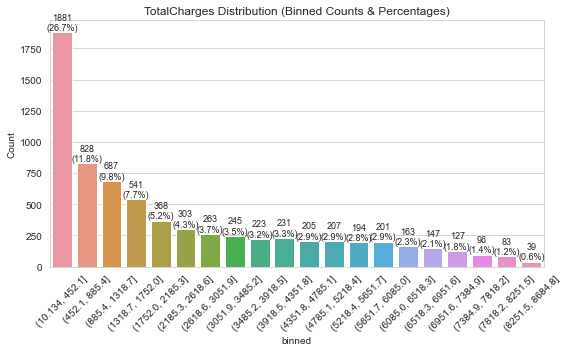

In [76]:
plot_numerical_binned_distribution(df, 'TotalCharges', bins=20)

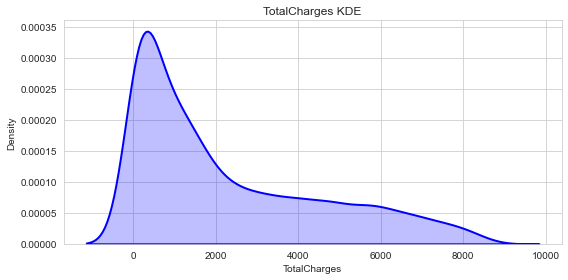

In [77]:
plot_numerical_kde(df, 'TotalCharges')

<Figure size 720x432 with 0 Axes>

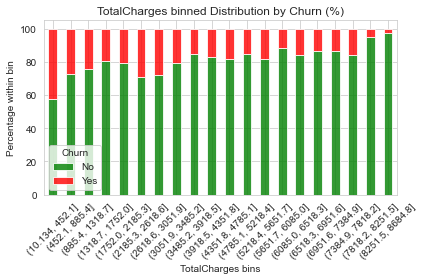

In [78]:
plot_numerical_binned_with_target(df, 'TotalCharges', bins=20)

In [79]:
numerical_to_target_plot_violin(df, 'TotalCharges')

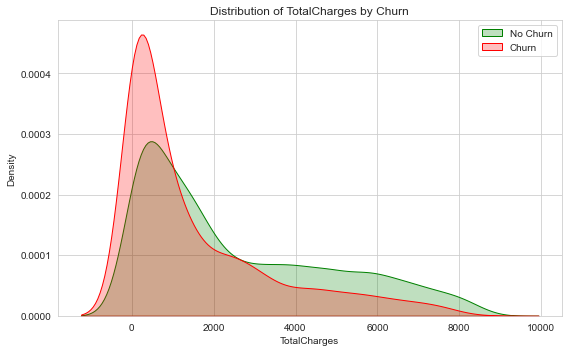

In [80]:
plot_numerical_distribution_by_target(df, 'TotalCharges')

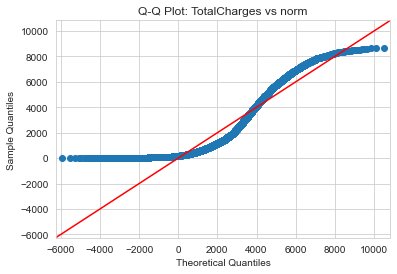

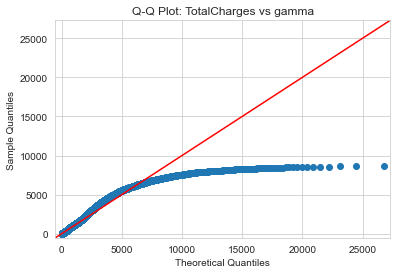

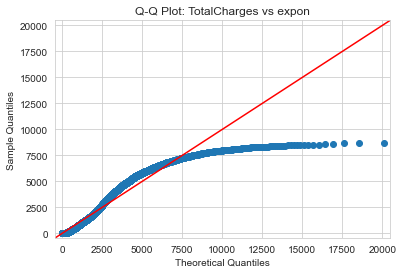

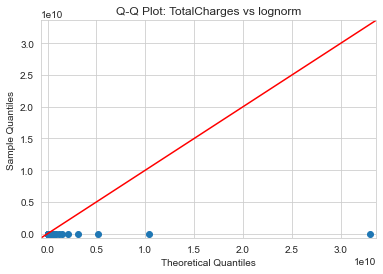

feature distribution  \
0  TotalCharges         norm   
1  TotalCharges        gamma   
2  TotalCharges        expon   
3  TotalCharges      lognorm   

                                              params   ks_stat           ks_p  \
0             (2283.300440841866, 2266.610180714535)  0.158881  1.586538e-155   
1  (0.6630487206613236, 18.799999999999997, 3418....  0.054344   1.721549e-18   
2                          (18.8, 2264.500440841866)  0.098159   1.980668e-59   
3  (6.296332385240978, 18.799999999999997, 3.9300...  0.589366   0.000000e+00   

   shapiro_p  
0        0.0  
1        NaN  
2        NaN  
3        NaN

In [81]:
fit_distribution(df, 'TotalCharges')

In [82]:
numerical_feature_analysis(df, 'TotalCharges', best_fit='gamma')


--- Descriptive statistics of 'TotalCharges' by Churn ---

Churn = No:
  Count: 5163
  Mean: 2555.344
  Std: 2329.457
  Min: 18.800
  Max: 8672.450

Churn = Yes:
  Count: 1869
  Mean: 1531.796
  Std: 1890.823
  Min: 18.850
  Max: 8684.800

--- Association Tests ---
Mann–Whitney U: U=6288982.000, p=0.0000
Effect size (r = U/(n1*n2)) = 0.652
Levene’s test p-value: 0.0000
KS test: statistic=0.224, p=0.0000
Point-biserial correlation: r=-0.199

--- MLE for best-fitting distribution (gamma) ---
Shape: 0.663049, Loc: 18.800000, Scale: 3418.129941


### 2.2 Tri-variate connections exploration

In [123]:
# Helper: prepare binary target
def prepare_binary_target(df, target='Churn'):
    if df[target].dtype == 'object':
        df[target+'_bin'] = df[target].map({'No':0,'Yes':1})
        return df, target+'_bin'
    else:
        return df, target

# Helper: bin numeric feature
def bin_numeric_feature(df, feature, bins=6, labels=None):
    """
    Bin numeric feature with meaningful ordered labels.
    """
    if labels is None:
        bin_edges = np.linspace(df[feature].min(), df[feature].max(), bins+1)
        labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]

    # Ordered categorical
    df[feature+'_bin'] = pd.cut(df[feature], bins=bin_edges, labels=labels, include_lowest=True, ordered=True)
    return df, feature+'_bin'

# Fit logistic regression with interaction
def fit_interaction_logit(df, feature1, feature2, target='Churn', bins=6):
    df, target_var = prepare_binary_target(df, target)

    # Bin numeric features if needed
    f1_is_numeric = np.issubdtype(df[feature1].dtype, np.number)
    f2_is_numeric = np.issubdtype(df[feature2].dtype, np.number)

    f1_col = feature1
    f2_col = feature2

    if f1_is_numeric:
        df, f1_col = bin_numeric_feature(df, feature1, bins=bins)
    if f2_is_numeric:
        df, f2_col = bin_numeric_feature(df, feature2, bins=bins)

    # Formula with interaction
    formula = f"{target_var} ~ {f1_col} * {f2_col}"

    model = smf.logit(formula=formula, data=df).fit(disp=False)

    print(f"\nLogistic Regression Interaction: {feature1} × {feature2}\n")
    print(model.summary())
    print("\nOdds Ratios:")
    print(pd.DataFrame({
        'OR': model.params.apply(lambda x: round(np.exp(x),3)),
        'p-value': model.pvalues
    }))

    return model, f1_col, f2_col, df


# Plot interaction
def plot_interaction(model, df, f1_col, f2_col, feature1, feature2, target='Churn'):
    """
    Plot predicted probability of churn across two features.
    Preserves ordered bins for numeric features.
    """
    # Determine unique values
    f1_categories = df[f1_col].cat.categories if pd.api.types.is_categorical_dtype(df[f1_col]) else df[f1_col].unique()
    f2_categories = df[f2_col].cat.categories if pd.api.types.is_categorical_dtype(df[f2_col]) else df[f2_col].unique()

    # Prediction grid
    pred_df = pd.DataFrame(list(itertools.product(f1_categories, f2_categories)),
                           columns=[f1_col, f2_col])

    # Preserve ordered categorical if applicable
    if pd.api.types.is_categorical_dtype(df[f1_col]):
        pred_df[f1_col] = pd.Categorical(pred_df[f1_col], categories=f1_categories, ordered=True)
    if pd.api.types.is_categorical_dtype(df[f2_col]):
        pred_df[f2_col] = pd.Categorical(pred_df[f2_col], categories=f2_categories, ordered=True)

    # Predict probabilities
    pred_df['pred_prob'] = model.predict(pred_df)

    # Plot
    plt.figure(figsize=(8,6))
    if not pd.api.types.is_categorical_dtype(df[f1_col]) and not pd.api.types.is_categorical_dtype(df[f2_col]):
        # numeric × numeric -> heatmap
        heatmap_data = pred_df.pivot(index=f2_col, columns=f1_col, values='pred_prob')
        sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
        plt.title(f'Predicted Probability of {target} (Heatmap)')
    else:
        # categorical / binned -> pointplot
        sns.pointplot(x=f1_col, y='pred_prob', hue=f2_col, data=pred_df,
                      order=f1_categories,
                      hue_order=f2_categories)
        plt.ylabel(f'Predicted Probability of {target}')
        plt.title(f'Interaction Effect: {feature1} × {feature2}')
    plt.show()


Logistic Regression Interaction: tenure × Contract

                           Logit Regression Results                           
Dep. Variable:              Churn_bin   No. Observations:                 7043
Model:                          Logit   Df Residuals:                     7025
Method:                           MLE   Df Model:                           17
Date:                Thu, 14 Aug 2025   Pseudo R-squ.:                  0.1900
Time:                        01:09:49   Log-Likelihood:                -3300.9
converged:                      False   LL-Null:                       -4075.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.0542      0.045      1.209      0.227      -0.034 

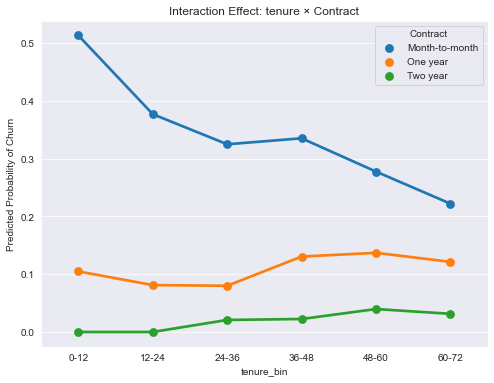

In [124]:
model, f1_col, f2_col, df_proc = fit_interaction_logit(df, 'tenure', 'Contract', target='Churn', bins=6)
plot_interaction(model, df_proc, f1_col, f2_col, 'tenure', 'Contract', target='Churn')

### 2.3 Correlations

The correlations presented here are all significant (p > 0.05) or masked.

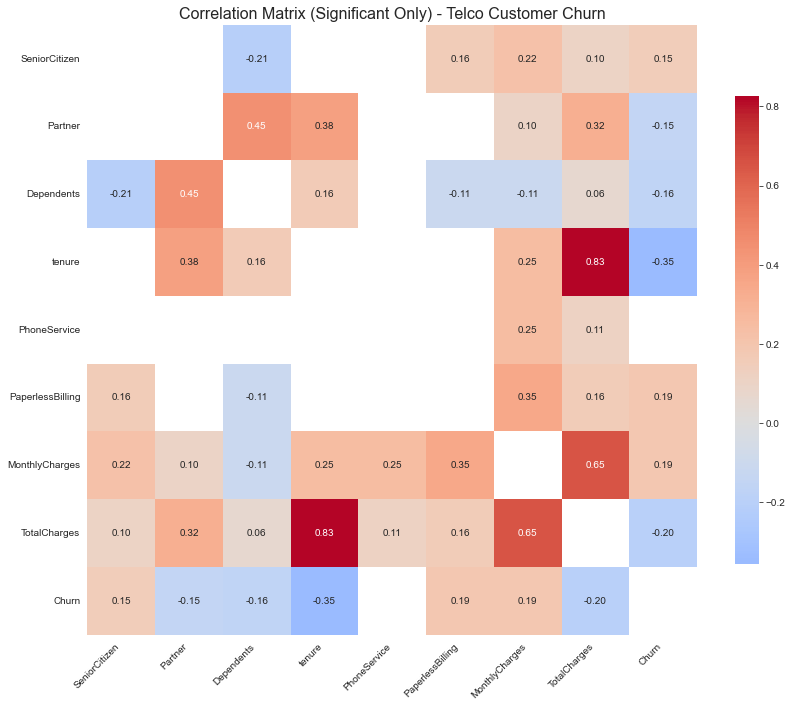

In [88]:
# Load dataset
df_corr = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Preprocess: Convert relevant boolean-like columns to 0/1
df_corr['Churn'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})
df_corr['Partner'] = df_corr['Partner'].map({'Yes': 1, 'No': 0})
df_corr['Dependents'] = df_corr['Dependents'].map({'Yes': 1, 'No': 0})
df_corr['PhoneService'] = df_corr['PhoneService'].map({'Yes': 1, 'No': 0})
df_corr['PaperlessBilling'] = df_corr['PaperlessBilling'].map({'Yes': 1, 'No': 0})

# Convert 'SeniorCitizen' to boolean (already numeric, just ensure it's 0/1)
df_corr['SeniorCitizen'] = df_corr['SeniorCitizen'].astype(int)

df_corr['TotalCharges'] = pd.to_numeric(df_corr['TotalCharges'], errors='coerce')

df_corr.dropna(inplace=True)

# Select only numeric columns
df_numeric = df_corr.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Compute p-values matrix
pval_matrix = pd.DataFrame(np.ones(corr_matrix.shape), columns=corr_matrix.columns, index=corr_matrix.index)
for col1 in df_numeric.columns:
    for col2 in df_numeric.columns:
        if col1 != col2:
            corr, pval = pearsonr(df_numeric[col1], df_numeric[col2])
            pval_matrix.loc[col1, col2] = pval

# Mask non-significant correlations (e.g., p > 0.05)
significance_mask = pval_matrix > 0.05

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,  # Center around 0
    square=True,
    cbar_kws={"shrink": .75},
    mask=significance_mask  # Mask non-significant cells
)
plt.title('Correlation Matrix (Significant Only) - Telco Customer Churn', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Classification task

### 3.1 preprocessing and encoding

In [104]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.dropna(inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.drop(['customerID', 'gender'], axis=1)
encoded_df = encode_telco_dataset(df, ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Churn'], NUMERICAL_FEATURES, CATEGORICAL_FEATURES)
encoded_df.head()

SeniorCitizen  Partner  Dependents  tenure  PhoneService  PaperlessBilling  \
0              0        1           0       1             0                 1   
1              0        0           0      34             1                 0   
2              0        0           0       2             1                 1   
3              0        0           0      45             0                 0   
4              0        0           0       2             1                 1   

   MonthlyCharges  TotalCharges  Churn  MultipleLines_No phone service  ...  \
0           29.85         29.85      0                               1  ...   
1           56.95       1889.50      0                               0  ...   
2           53.85        108.15      1                               0  ...   
3           42.30       1840.75      0                               1  ...   
4           70.70        151.65      1                               0  ...   

   TechSupport_Yes  StreamingTV_No internet service  StreamingTV_Yes  \
0                0                                0                0   
1                0                                0                0   
2                0                                0                0   
3                1                                0                0   
4                0                                0                0   

   StreamingMovies_No internet service  StreamingMovies_Yes  \
0                                    0                    0   
1                                    0                    0   
2                                    0                    0   
3                                    0                    0   
4                                    0                    0   

   Contract_One year  Contract_Two year  \
0                  0                  0   
1                  1                  0   
2                  0                  0   
3                  1                  0   
4                  0                  0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  
0                           0  
1                           1  
2                           1  
3                           0  
4                           0  

[5 rows x 30 columns]

### 3.1 Split dataset

In [105]:
X = encoded_df.drop(columns=[TARGET_FEATURE])
y = encoded_df[TARGET_FEATURE]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,           # Data
    test_size=0.2,  # 20% for testing, 80% for training
    random_state=42 # Ensures reproducibility
)

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Shapes:
X_train: (5634, 29)
y_train: (5634,)
X_test: (1409, 29)
y_test: (1409,)


### 3.2 Train and optimize

In [106]:
best_model, auc_eval = train_and_optimize(X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'subsample': 0.85, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Validation ROC-AUC: 0.8651


### 3.3 Test model

 Model Evaluation: XGB baseline

Accuracy: 0.8141

 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.54      0.61       373

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.81      0.81      0.81      1409



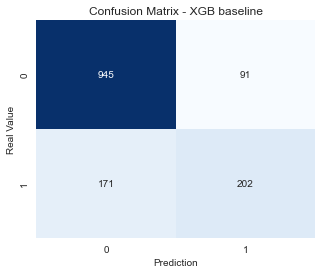

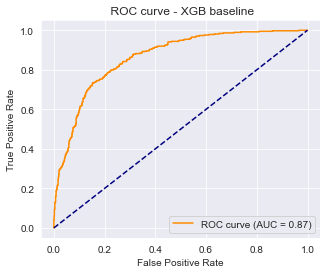

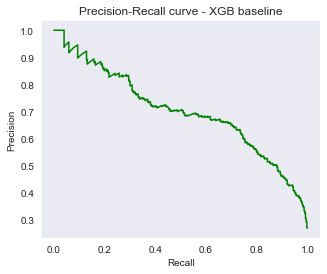

In [113]:
evaluate_model('XGB baseline', best_model, X_test, y_test)

### 3.4 Feature importance

#### 3.4.1 Total gain

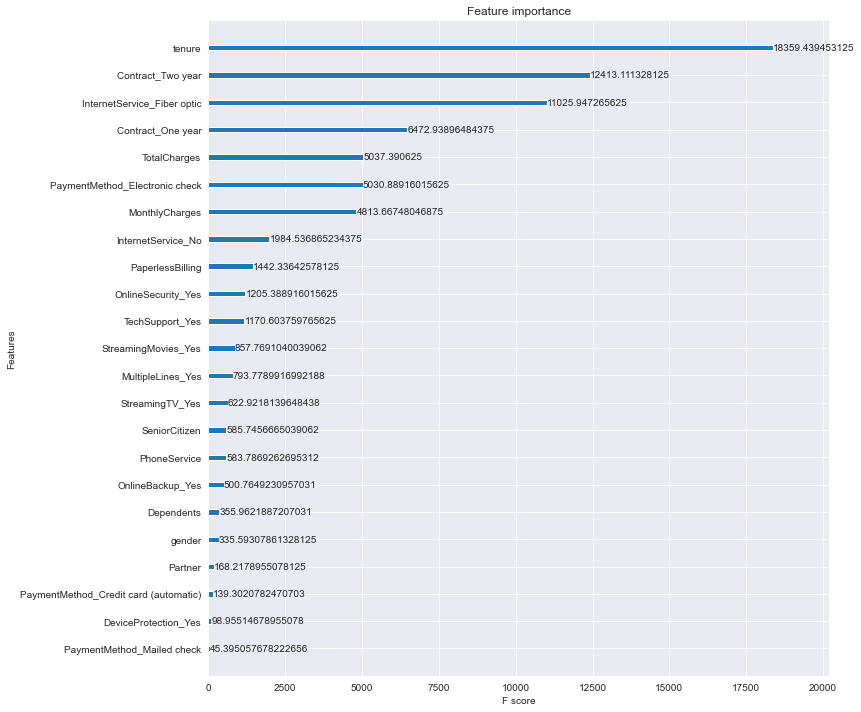

In [51]:
fig, ax = plt.subplots(figsize=(12, 10))
xgb.plot_importance(best_model, importance_type='total_gain', max_num_features=50, ax=ax)
plt.tight_layout()
plt.show()

#### 3.4.1 Shap

Calculating SHAP values...


 92%|==================  | 648/705 [00:12<00:01]       

Generating summary plot...


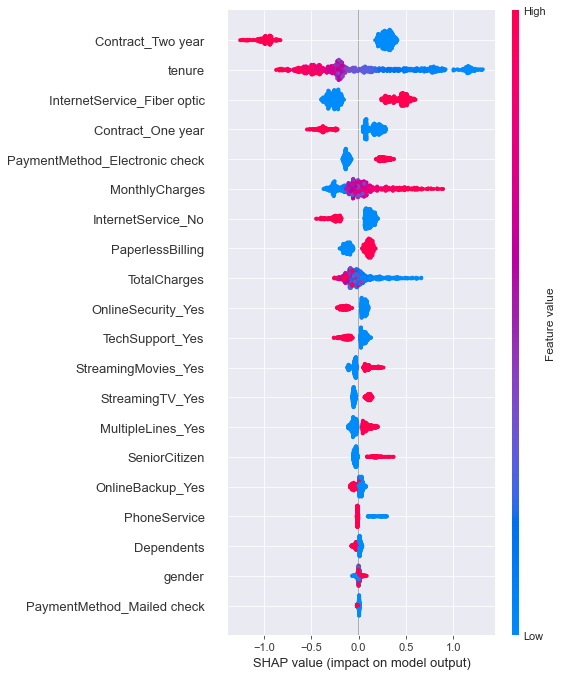

In [57]:
explain_xgboost_with_shap(best_model, X_test)